#### Installation & mount drive

In [ ]:
!pip install praw prawcore nltk vaderSentiment bertopic transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load dependencies

In [ ]:
import praw
import prawcore
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime

# from transformers import pipeline
nltk.download('stopwords')

import torch
import numpy as np
import pickle
from bertopic import BERTopic
from wordcloud import WordCloud
# SamLowe/roberta-base-go_emotions
from transformers import pipeline
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize

rb_classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
db_classifier = pipeline(task="text-classification", model="joeddav/distilbert-base-uncased-go-emotions-student", top_k=None)

topic_model = BERTopic.load("heyitskim1912/TopicModelling")


analyzer = SentimentIntensityAnalyzer()

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first GPU
    print("using GPU")
else:
    device = torch.device("cpu")  # Use CPU if no GPU is available
    print("using CPU")


my_client_id = "C-jEYYIDYXzGxFRq5nDy3w"
my_client_secret = "4TVajUEVHnLPQvQZxAMr8SJBwU2Ckw"
my_user_agent = "spark1217"

reddit = praw.Reddit(client_id=my_client_id, client_secret=my_client_secret, user_agent=my_user_agent)


functions: preprocessing text, reddit scraping, sentiment

In [ ]:

# Define a function to remove stop words
def remove_stop_words(text):
  stop_words = nltk.corpus.stopwords.words('english')
  return ' '.join([word for word in text.split() if word not in stop_words])

# Define a function to lowercase the text
def lowercase_text(text):
  return text.lower()


# Remove emojis & punctuation
def replace_emojis(text):
  emoji_pattern = r'[^\w\s]'
  text = str(text)
  return re.sub(emoji_pattern, '', text)

def drop_rows_with_empty_text(df):

    df = df.dropna(subset=['content'])
    df = df[df['content'].str.len() >= 1]
    return df


# for reddit scraping, check user
def check_if_user_exists(name):
    try:
        reddit.redditor(name).id
    except prawcore.exceptions.NotFound:
        return False
    except AttributeError:
        return False
    return True


#Define a function to perform sentiment analysis using VADER
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

def get_emotion_prediction_rb(text):
    try:
        emotion = rb_classifier(text)
    except:
        emotion = ''
    return emotion

def get_emotion_prediction_db(text):
    try:
        emotion = db_classifier(text)
    except:
        emotion = ''
    return emotion

#### reddit scraping

In [ ]:
# all, story, love, friendship

top_users = list(reddit.subreddit('friendship').top(limit=100, params={'t': 'all'}))

authors = []
for idx in range(len(top_users)):
    a = top_users[idx].author
    if a:
        authors.append(a.name)



submission_ids = []
for u in authors:
    if check_if_user_exists(u):
        for comment in reddit.redditor(u).submissions.hot(limit=1000):
            try:
                submission_ids.append(comment.id)
            except:
                continue

# save as pickle
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/submission_ids_new.pkl', 'wb') as f:
    pickle.dump(submission_ids, f)


In [ ]:
#load pickle
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/submission_ids_new.pkl', 'rb') as f:
    submission_ids = pickle.load(f)

#load existing data
existing = pd.read_csv('/content/drive/Shareddrives/Fall23_NLPproject/data/userReddit.csv', low_memory=True)

# scrape reddit post by submission ids
df = pd.DataFrame(columns=['content', 'userId','createdTime', 'sentiment','preprocessed_content'])

for id in submission_ids:
    try:
        post = reddit.submission(id=id)
        content = post.title + '\n' + post.selftext

        new_row = {'content': content, 'userId': post.author, 'createdTime': post.created_utc, 'sentiment':'','preprocessed_content':''}
        df = df.append(new_row, ignore_index=True)
    except:
        break





#### Preprocessing

In [ ]:
# load data

df=pd.read_csv('/content/drive/Shareddrives/Fall23_NLPproject/data/userReddit_emotion.csv', low_memory=True)
df.head()

content            userId  \
0  Hi I'm Rick Astley. Good to be back here again...  ReallyRickAstley   
1  Live stream chat with my new album and upcomin...  ReallyRickAstley   
2                                     Coming soon…\n  ReallyRickAstley   
3        Rick Astley (me) - Never Gonna Stop [Pop]\n  ReallyRickAstley   
4          Rick Astley (me) - Dippin My Feet [Pop]\n  ReallyRickAstley   

    createdTime                                          sentiment  \
0  1.697728e+09  {'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...   
1  1.697647e+09  {'neg': 0.06, 'neu': 0.713, 'pos': 0.227, 'com...   
2  1.697149e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
3  1.693502e+09  {'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'comp...   
4  1.689269e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

                                preprocessed_content sentiment_word  \
0  hi im rick astley good back my new album are w...        neutral   
1  live stream chat new album upcoming ama hi im ...        neutral   
2                                        coming soon        neutral   
3                   rick astley never gonna stop pop        neutral   
4                     rick astley dippin my feet pop        neutral   

                                             emotion top_emotion  
0  [[{'label': 'love', 'score': 0.6530721783638},...        love  
1  [[{'label': 'optimism', 'score': 0.87548935413...    optimism  
2  [[{'label': 'neutral', 'score': 0.864529907703...     neutral  
3  [[{'label': 'neutral', 'score': 0.937943339347...     neutral  
4  [[{'label': 'neutral', 'score': 0.954831600189...     neutral

skip if already done

In [ ]:
# preprocess
df['preprocessed_content'] = df['content'].apply(replace_emojis)
df['preprocessed_content'] = df['preprocessed_content'].apply(remove_stop_words)
df['preprocessed_content'] = df['preprocessed_content'].apply(lowercase_text)
df = drop_rows_with_empty_text(df)



# Apply the function to the 'tokens' column of the DataFrame
df['sentiment'] = df['preprocessed_content'].apply(get_sentiment)


### analysis

In [ ]:

df = pd.read_csv('/content/drive/Shareddrives/Fall23_NLPproject/data/userReddit_emotion.csv', low_memory=True)
df.head()

content            userId  \
0  Hi I'm Rick Astley. Good to be back here again...  ReallyRickAstley   
1  Live stream chat with my new album and upcomin...  ReallyRickAstley   
2                                     Coming soon…\n  ReallyRickAstley   
3        Rick Astley (me) - Never Gonna Stop [Pop]\n  ReallyRickAstley   
4          Rick Astley (me) - Dippin My Feet [Pop]\n  ReallyRickAstley   

    createdTime                                          sentiment  \
0  1.697728e+09  {'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...   
1  1.697647e+09  {'neg': 0.06, 'neu': 0.713, 'pos': 0.227, 'com...   
2  1.697149e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
3  1.693502e+09  {'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'comp...   
4  1.689269e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

                                preprocessed_content sentiment_word  \
0  hi im rick astley good back my new album are w...        neutral   
1  live stream chat new album upcoming ama hi im ...        neutral   
2                                        coming soon        neutral   
3                   rick astley never gonna stop pop        neutral   
4                     rick astley dippin my feet pop        neutral   

                                             emotion top_emotion  
0  [[{'label': 'love', 'score': 0.6530721783638},...        love  
1  [[{'label': 'optimism', 'score': 0.87548935413...    optimism  
2  [[{'label': 'neutral', 'score': 0.864529907703...     neutral  
3  [[{'label': 'neutral', 'score': 0.937943339347...     neutral  
4  [[{'label': 'neutral', 'score': 0.954831600189...     neutral

In [ ]:
# get emotion (already saved in the data file)
df['emotion'] = df['preprocessed_content'].apply(get_emotion_prediction_rb)


Token indices sequence length is longer than the specified maximum sequence length for this model (6638 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
def top_emotion(text):
    # print(text[0][0])
    try:
        return text[0][0]['label']
    except:
        return ''

df['top_emotion'] = df['emotion'].apply(top_emotion)
df.head()

content            userId  \
0  Hi I'm Rick Astley. Good to be back here again...  ReallyRickAstley   
1  Live stream chat with my new album and upcomin...  ReallyRickAstley   
2                                     Coming soon…\n  ReallyRickAstley   
3        Rick Astley (me) - Never Gonna Stop [Pop]\n  ReallyRickAstley   
4          Rick Astley (me) - Dippin My Feet [Pop]\n  ReallyRickAstley   

    createdTime                                          sentiment  \
0  1.697728e+09  {'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...   
1  1.697647e+09  {'neg': 0.06, 'neu': 0.713, 'pos': 0.227, 'com...   
2  1.697149e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
3  1.693502e+09  {'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'comp...   
4  1.689269e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

                                preprocessed_content sentiment_word  \
0  hi im rick astley good back my new album are w...        neutral   
1  live stream chat new album upcoming ama hi im ...        neutral   
2                                        coming soon        neutral   
3                   rick astley never gonna stop pop        neutral   
4                     rick astley dippin my feet pop        neutral   

                                             emotion top_emotion  
0  [[{'label': 'love', 'score': 0.6530721783638},...        love  
1  [[{'label': 'optimism', 'score': 0.87548935413...    optimism  
2  [[{'label': 'neutral', 'score': 0.864529907703...     neutral  
3  [[{'label': 'neutral', 'score': 0.937943339347...     neutral  
4  [[{'label': 'neutral', 'score': 0.954831600189...     neutral

In [ ]:
df['top_emotion'].value_counts()

neutral           3405
admiration         281
love               260
curiosity          168
gratitude          158
sadness            155
joy                127
amusement          113
annoyance           83
disappointment      81
fear                78
excitement          74
desire              64
anger               55
confusion           55
disapproval         47
remorse             45
optimism            44
approval            37
surprise            37
nervousness         34
caring              33
realization         32
disgust             18
embarrassment        8
pride                3
Name: top_emotion, dtype: int64

In [ ]:
# Convert the 'createdTime' column to datetime format
# df['createdTime'] = pd.to_datetime(df['createdTime'], unit='s')

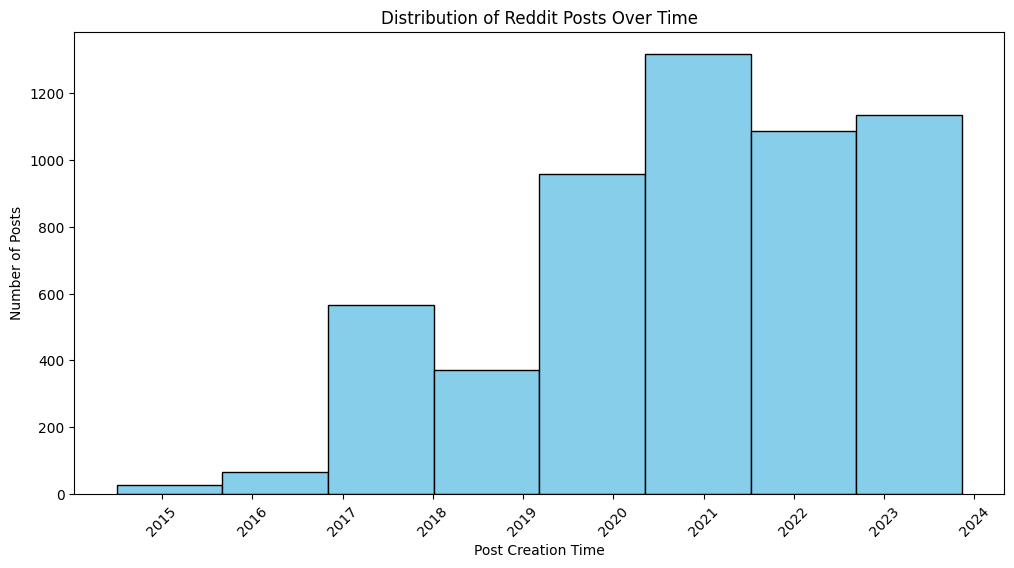

In [ ]:

# Plot the distribution of posts over time
plt.figure(figsize=(12, 6))
plt.hist(df['createdTime'], bins=8, color='skyblue', edgecolor='black')

# Format the x-axis as dates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title('Distribution of Reddit Posts Over Time')
plt.xlabel('Post Creation Time')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### topic modeling with 8 bins

[1.40423740e+09 1.44117777e+09 1.47811815e+09 1.51505852e+09
 1.55199889e+09 1.58893926e+09 1.62587963e+09 1.66282001e+09] [1.44117777e+09 1.47811815e+09 1.51505852e+09 1.55199889e+09
 1.58893926e+09 1.62587963e+09 1.66282001e+09 1.69976038e+09]


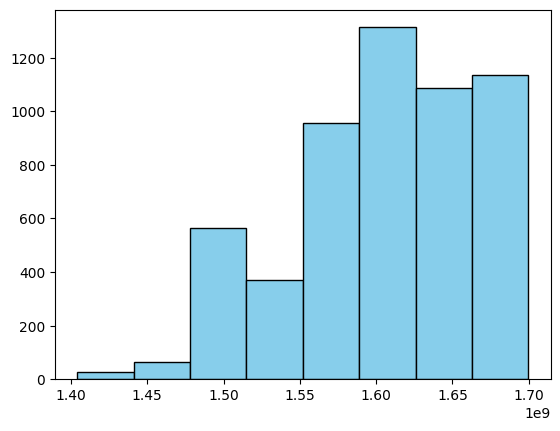

In [ ]:
#
counts, bins, patches = plt.hist(df['createdTime'], bins=8, color='skyblue', edgecolor='black')
start = bins[:-1]
end = bins[1:]
print(start, end)

In [ ]:

topic_modeling = []


for i in range(len(start)):
    filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
    sentences = filtered_df['preprocessed_content'].astype(str)


    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(sentences)

    freq = topic_model.get_topic_info(); freq.head(5)

    topic_modeling.append(topic_model.get_topic(0))  # Select the most frequent topic

In [ ]:
topic_modeling

[False,
 [('get', 0.05062334172186505),
  ('may', 0.043479114763390156),
  ('match', 0.04096463957803625),
  ('anthology', 0.03737145403169152),
  ('stories', 0.03737145403169152),
  ('first', 0.031112200222932675),
  ('want', 0.030435380334373107),
  ('contribution', 0.02978792289349643),
  ('im', 0.027750125034352216),
  ('fun', 0.025754255517997513)],
 [('anyone', 0.04900608656327094),
  ('else', 0.04177926473861602),
  ('think', 0.03469821821285465),
  ('removed', 0.03466853750698484),
  ('game', 0.03280278522838391),
  ('like', 0.03055046726654999),
  ('would', 0.029432574374096188),
  ('get', 0.029199888344517037),
  ('good', 0.024311155752348074),
  ('still', 0.019645256082605377)],
 [('alliance', 0.0350409666550244),
  ('server', 0.03185542423184037),
  ('players', 0.030014766392580668),
  ('horde', 0.030014766392580668),
  ('play', 0.028087923781646193),
  ('pvp', 0.02738284714580483),
  ('servers', 0.024658353573788473),
  ('anyone', 0.023219199892638723),
  ('game', 0.022795

In [ ]:
# save it to pickle
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_timeframe.pickle', 'wb') as f:
    # Pickle the list to the file
    pickle.dump(topic_modeling, f)

#### sentiment in word

In [ ]:

def word_sentiment(text):
    sentiment = analyzer.polarity_scores(str(text))
    # max_item = max(sentiment.items(), key=lambda item: item[1])
    # return max_item[0]
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_word'] = df['preprocessed_content'].apply(word_sentiment)

In [ ]:
df['sentiment_word'].value_counts()

positive    2530
neutral     1746
negative    1247
Name: sentiment_word, dtype: int64

sentiment stat

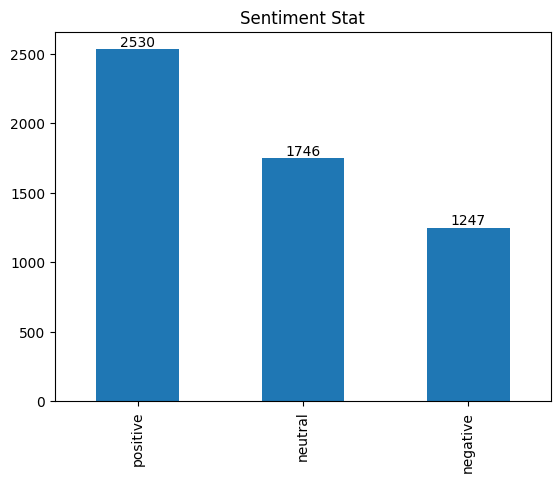

In [ ]:
sent_count = df['sentiment_word'].value_counts()
sent_count.plot(kind='bar', title='Sentiment Stat')
bar_midpoints = [x for x in np.arange(3)]
formatted_values = [int(value) for value in sent_count]
for i, value in enumerate(formatted_values):
    plt.text(bar_midpoints[i], sent_count[i] + 0.1, value, ha='center', va='bottom')


plt.show()

word cloud of sentiment

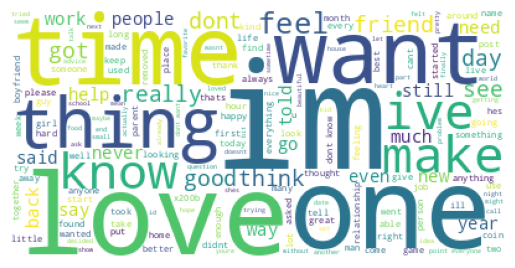

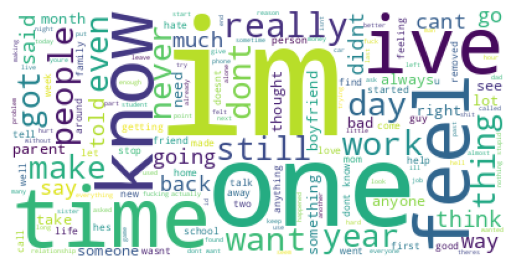

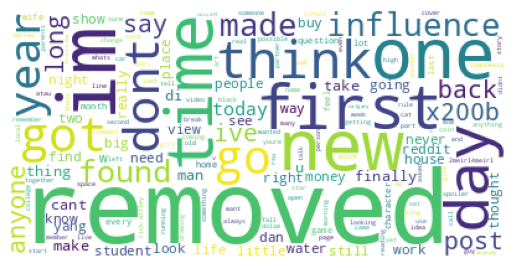

In [ ]:

for i in ['positive','negative','neutral']:
    filtered_df = df[(df['sentiment_word'] == i)]
    sentences = filtered_df['preprocessed_content'].astype(str)
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate(sentences.str.cat(sep=' '))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

#### topic modeling for sentiment

In [ ]:


topic_modeling = pd.DataFrame(columns=['sentiment','topics'])


for i in ['positive','negative','neutral']:
    filtered_df = df[(df['sentiment_word'] == i)]
    sentences = filtered_df['preprocessed_content'].astype(str)


    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(sentences)

    # freq = topic_model.get_topic_info(); freq.head(5)

    topic_modeling.append(topic_model.get_topic(0))  # Select the most frequent topic
    new_row = {'sentiment': i, 'topics':topic_model.get_topic(0)}
    topic_modeling = topic_modeling.append(new_row, ignore_index=True)

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

2023-11-14 23:06:07,517 - BERTopic - Transformed documents to Embeddings
2023-11-14 23:06:25,781 - BERTopic - Reduced dimensionality
2023-11-14 23:06:27,860 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

2023-11-14 23:07:28,521 - BERTopic - Transformed documents to Embeddings
2023-11-14 23:07:34,443 - BERTopic - Reduced dimensionality
2023-11-14 23:07:34,575 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

2023-11-14 23:08:01,992 - BERTopic - Transformed documents to Embeddings
2023-11-14 23:08:15,271 - BERTopic - Reduced dimensionality
2023-11-14 23:08:15,525 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_modeling.head()

sentiment                                             topics
0  positive  [(im, 0.016969126804141695), (like, 0.01403698...
1  negative  [(im, 0.02885419300303173), (parents, 0.021853...
2   neutral  [(removed, 0.14109769233855263), (pc, 0.031426...

In [ ]:
# save as pickle
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_sentiment.pickle', 'wb') as f:
    # Pickle the list to the file
    pickle.dump(topic_modeling, f)

#### some tests

In [ ]:
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_sentiment.pickle', 'rb') as pickle_file:
    data1 = pickle.load(pickle_file)

# Print the contents of the data
print(data1)

  sentiment                                             topics
0  positive  [(im, 0.016969126804141695), (like, 0.01403698...
1  negative  [(im, 0.02885419300303173), (parents, 0.021853...
2   neutral  [(removed, 0.14109769233855263), (pc, 0.031426...


In [ ]:
data1['topics'][0]

[('im', 0.016969126804141695),
 ('like', 0.014036982325478127),
 ('dont', 0.013845594930178857),
 ('love', 0.013505990142994),
 ('feel', 0.012515470818255731),
 ('time', 0.012109824366797752),
 ('know', 0.012092424223179254),
 ('he', 0.01203494071895331),
 ('told', 0.01177710198339463),
 ('said', 0.011391249984068548)]

In [ ]:
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_timeframe.pickle', 'rb') as pickle_file:
    data = pickle.load(pickle_file)

# Print the contents of the data
print(data)

[False, [('get', 0.05062334172186505), ('may', 0.043479114763390156), ('match', 0.04096463957803625), ('anthology', 0.03737145403169152), ('stories', 0.03737145403169152), ('first', 0.031112200222932675), ('want', 0.030435380334373107), ('contribution', 0.02978792289349643), ('im', 0.027750125034352216), ('fun', 0.025754255517997513)], [('anyone', 0.04900608656327094), ('else', 0.04177926473861602), ('think', 0.03469821821285465), ('removed', 0.03466853750698484), ('game', 0.03280278522838391), ('like', 0.03055046726654999), ('would', 0.029432574374096188), ('get', 0.029199888344517037), ('good', 0.024311155752348074), ('still', 0.019645256082605377)], [('alliance', 0.0350409666550244), ('server', 0.03185542423184037), ('players', 0.030014766392580668), ('horde', 0.030014766392580668), ('play', 0.028087923781646193), ('pvp', 0.02738284714580483), ('servers', 0.024658353573788473), ('anyone', 0.023219199892638723), ('game', 0.02279526429800983), ('else', 0.022248599391824955)], [('im', 

In [ ]:
data[1]

[('get', 0.05062334172186505),
 ('may', 0.043479114763390156),
 ('match', 0.04096463957803625),
 ('anthology', 0.03737145403169152),
 ('stories', 0.03737145403169152),
 ('first', 0.031112200222932675),
 ('want', 0.030435380334373107),
 ('contribution', 0.02978792289349643),
 ('im', 0.027750125034352216),
 ('fun', 0.025754255517997513)]

#### POS tagging

In [ ]:

# pos tagging
# sentiment per year
# words per year
# individual emotion fluctuation

# df = pd.read_csv('/content/drive/Shareddrives/Fall23_NLPproject/data/userReddit.csv', low_memory=True)
df = df.dropna(subset=['preprocessed_content'])

In [ ]:
nltk.download('punkt')  # Download the Punkt tokenizer
nltk.download('averaged_perceptron_tagger')  # Download the averaged perceptron POS tagger



def pos_tag_text(text):
    return nltk.pos_tag(nltk.word_tokenize(text))

def extract_verb(pos_tags):
    verbs = []
    for word, tag in pos_tags:
        if tag in ('VB') or tag in ('VBD') or tag in ('VBG') or tag in ('VBN'):
            verbs.append(word)

    return verbs

def extract_nouns(pos_tags):
    nouns = []
    for word, tag in pos_tags:
        if tag in ('NN') or tag in ('NNS') or tag in ('NNP') or tag in ('NNPS'):
            nouns.append(word)

    return nouns

def extract_adj(pos_tags):
    adj = []
    for word, tag in pos_tags:
        if tag in ('JJ') or tag in ('JJS') or tag in ('JJR'):
            adj.append(word)

    return adj


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df['POS_tags'] = df['preprocessed_content'].apply(pos_tag_text)
df['nouns'] = df['POS_tags'].apply(extract_nouns)
# df['verbs'] = df['POS_tags'].apply(extract_verb)
# df['adj'] = df['POS_tags'].apply(extract_adj)

In [ ]:
df = df.dropna(subset=['nouns'])
df.head()

content            userId  \
0  Hi I'm Rick Astley. Good to be back here again...  ReallyRickAstley   
1  Live stream chat with my new album and upcomin...  ReallyRickAstley   
2                                     Coming soon…\n  ReallyRickAstley   
3        Rick Astley (me) - Never Gonna Stop [Pop]\n  ReallyRickAstley   
4          Rick Astley (me) - Dippin My Feet [Pop]\n  ReallyRickAstley   

    createdTime                                          sentiment  \
0  1.697728e+09  {'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...   
1  1.697647e+09  {'neg': 0.06, 'neu': 0.713, 'pos': 0.227, 'com...   
2  1.697149e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
3  1.693502e+09  {'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'comp...   
4  1.689269e+09  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

                                preprocessed_content sentiment_word  \
0  hi im rick astley good back my new album are w...        neutral   
1  live stream chat new album upcoming ama hi im ...        neutral   
2                                        coming soon        neutral   
3                   rick astley never gonna stop pop        neutral   
4                     rick astley dippin my feet pop        neutral   

                                             emotion top_emotion  \
0  [[{'label': 'love', 'score': 0.6530721783638},...        love   
1  [[{'label': 'optimism', 'score': 0.87548935413...    optimism   
2  [[{'label': 'neutral', 'score': 0.864529907703...     neutral   
3  [[{'label': 'neutral', 'score': 0.937943339347...     neutral   
4  [[{'label': 'neutral', 'score': 0.954831600189...     neutral   

                                            POS_tags  \
0  [(hi, NN), (im, NN), (rick, NN), (astley, NN),...   
1  [(live, JJ), (stream, NN), (chat, WP), (new, J...   
2                        [(coming, VBG), (soon, RB)]   
3  [(rick, NN), (astley, NN), (never, RB), (gon, ...   
4  [(rick, NN), (astley, NN), (dippin, NN), (my, ...   

                                               nouns  
0  [hi, im, rick, astley, album, pop, x, studio, ...  
1  [stream, album, ama, hi, im, party, facebook, ...  
2                                                 []  
3                                [rick, astley, pop]  
4                       [rick, astley, dippin, feet]

#### Topic modeling with POS tagging

noun

In [ ]:


topic_modeling_n = []


for i in range(len(start)):
    filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
    sentences = filtered_df['nouns'].astype(str)


    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(sentences)

    freq = topic_model.get_topic_info(); freq.head(5)

    topic_modeling_n.append(topic_model.get_topic(0))  # Select the most frequent topic

In [ ]:
topic_modeling_n

[False,
 [('im', 0.07070714932235976),
  ('week', 0.0489824013877507),
  ('years', 0.0489824013877507),
  ('hair', 0.0489824013877507),
  ('today', 0.047128677697072324),
  ('parents', 0.045527835941318005),
  ('lot', 0.0426513865374052),
  ('meds', 0.0426513865374052),
  ('medication', 0.0426513865374052),
  ('day', 0.04081866782312559)],
 [('time', 0.0468809800823523),
  ('im', 0.043433229684021905),
  ('parents', 0.039210533196276334),
  ('year', 0.03839735366421721),
  ('anyone', 0.03789634257305968),
  ('school', 0.036558311919450664),
  ('home', 0.03190843032250393),
  ('hes', 0.03142586756369176),
  ('people', 0.030450262775363654),
  ('day', 0.030450262775363654)],
 [('character', 0.05322003026708963),
  ('alliance', 0.04488512430696412),
  ('pvp', 0.04048666678607737),
  ('world', 0.0392744837685936),
  ('players', 0.03820713268810728),
  ('game', 0.03725402118696274),
  ('horde', 0.03590441701656142),
  ('legion', 0.03590441701656142),
  ('theres', 0.03560894490979663),
  ('a

Topic modeling with POS tagging - verb

In [ ]:

topic_modeling_v = []


for i in range(len(start)):
    filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
    sentences = filtered_df['verbs'].astype(str)


    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(sentences)

    freq = topic_model.get_topic_info(); freq.head(5)

    topic_modeling_v.append(topic_model.get_topic(0))  # Select the most frequent topic

In [ ]:
topic_modeling_v

[False,
 False,
 [('going', 0.05737053421234411),
  ('dating', 0.045718456815674734),
  ('said', 0.045024226499513494),
  ('get', 0.04213916727510995),
  ('told', 0.03576604662700012),
  ('made', 0.03576604662700012),
  ('go', 0.03490309232295147),
  ('making', 0.03312588466411212),
  ('take', 0.029342248324329512),
  ('started', 0.028342614601110844)],
 [('got', 0.06120755987564552),
  ('looking', 0.055944721919466596),
  ('made', 0.048374857744068536),
  ('get', 0.044308648506559696),
  ('going', 0.040019092242303524),
  ('trying', 0.037779378822469976),
  ('wondering', 0.037779378822469976),
  ('know', 0.03546894294840378),
  ('love', 0.03308094451574767),
  ('go', 0.03308094451574767)],
 [('said', 0.049626622537945496),
  ('told', 0.0492913220175802),
  ('going', 0.0492913220175802),
  ('got', 0.04724260129485438),
  ('get', 0.0453069841707916),
  ('go', 0.036290391023962254),
  ('made', 0.034199513565775226),
  ('went', 0.03375806181092259),
  ('wanted', 0.0333251968822242),
  ('g

Topic modeling with POS tagging - adj

In [ ]:
topic_modeling_a = []


for i in range(len(start)):
    filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
    sentences = filtered_df['adj'].astype(str)


    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(sentences)

    freq = topic_model.get_topic_info(); freq.head(5)

    topic_modeling_a.append(topic_model.get_topic(0))  # Select the most frequent topic

In [ ]:
topic_modeling_a

[False,
 False,
 [('good', 0.06922351678287807),
  ('im', 0.057243792031739814),
  ('last', 0.05183892625318067),
  ('great', 0.04375986697292377),
  ('dont', 0.04254934933088814),
  ('ive', 0.04254934933088814),
  ('first', 0.038820672735789374),
  ('new', 0.03624664776230235),
  ('next', 0.03359391316561216),
  ('able', 0.03359391316561216)],
 [('im', 0.06991548477608407),
  ('new', 0.05936233459668853),
  ('good', 0.057502543119898636),
  ('ive', 0.05561028482434048),
  ('first', 0.05172161060501256),
  ('high', 0.04559793030946637),
  ('able', 0.039062856299753174),
  ('great', 0.039062856299753174),
  ('sure', 0.039062856299753174),
  ('last', 0.036776964724280305)],
 [('ive', 0.07217856521583414),
  ('im', 0.07217856521583414),
  ('new', 0.05446798438278781),
  ('much', 0.0520390871906847),
  ('last', 0.04751754633677859),
  ('first', 0.045440650075547116),
  ('good', 0.0449144729703413),
  ('happy', 0.04004341421708688),
  ('bad', 0.03836112333250507),
  ('little', 0.03779329223

In [ ]:
with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_noun', 'wb') as f:
    # Pickle the list to the file
    pickle.dump(topic_modeling_n, f)

with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_verb', 'wb') as f:
    # Pickle the list to the file
    pickle.dump(topic_modeling_v, f)

with open('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_adj', 'wb') as f:
    # Pickle the list to the file
    pickle.dump(topic_modeling_a, f)

#### Topic model different # of bins

[1.40423740e+09 1.41014786e+09 1.41605832e+09 1.42196878e+09
 1.42787924e+09 1.43378970e+09 1.43970016e+09 1.44561062e+09
 1.45152108e+09 1.45743154e+09 1.46334200e+09 1.46925246e+09
 1.47516292e+09 1.48107338e+09 1.48698384e+09 1.49289429e+09
 1.49880475e+09 1.50471521e+09 1.51062567e+09 1.51653613e+09
 1.52244659e+09 1.52835705e+09 1.53426751e+09 1.54017797e+09
 1.54608843e+09 1.55199889e+09 1.55790935e+09 1.56381981e+09
 1.56973027e+09 1.57564073e+09 1.58155119e+09 1.58746165e+09
 1.59337211e+09 1.59928257e+09 1.60519303e+09 1.61110349e+09
 1.61701394e+09 1.62292440e+09 1.62883486e+09 1.63474532e+09
 1.64065578e+09 1.64656624e+09 1.65247670e+09 1.65838716e+09
 1.66429762e+09 1.67020808e+09 1.67611854e+09 1.68202900e+09
 1.68793946e+09 1.69384992e+09] [1.41014786e+09 1.41605832e+09 1.42196878e+09 1.42787924e+09
 1.43378970e+09 1.43970016e+09 1.44561062e+09 1.45152108e+09
 1.45743154e+09 1.46334200e+09 1.46925246e+09 1.47516292e+09
 1.48107338e+09 1.48698384e+09 1.49289429e+09 1.49880

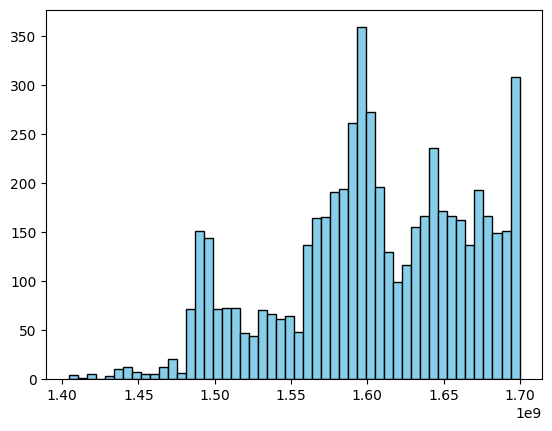

In [ ]:
counts, bins, patches = plt.hist(df['createdTime'], bins=50, color='skyblue', edgecolor='black')
start = bins[:-1]
end = bins[1:]
print(start, end, len(start))

In [ ]:
topic_modeling_50 = []

for i in range(len(start)):
    try:
        filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
        sentences = filtered_df['nouns'].astype(str)


        topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
        topics, probs = topic_model.fit_transform(sentences)

        freq = topic_model.get_topic_info(); freq.head(5)
        temp = {}
        temp['starting_idx'] = i
        temp['topics'] = topic_model.get_topic(0)
        topic_modeling_50.append(temp)  # Select the most frequent topic

    except:
        continue

print(topic_modeling_50)

In [ ]:
for i in range(len(topic_modeling_50)):
    print(topic_modeling_50[i])

{'starting_idx': 5, 'topics': False}
{'starting_idx': 6, 'topics': False}
{'starting_idx': 10, 'topics': False}
{'starting_idx': 11, 'topics': False}
{'starting_idx': 13, 'topics': [('dd', 0.13681305118135698), ('song', 0.13681305118135698), ('power', 0.13681305118135698), ('dundee', 0.13681305118135698), ('dps', 0.09835093914512455), ('city', 0.09835093914512455), ('alliance', 0.09835093914512455), ('dog', 0.09835093914512455), ('butterfly', 0.09835093914512455), ('humans', 0.09835093914512455)]}
{'starting_idx': 14, 'topics': [('game', 0.1369311758165814), ('gold', 0.09934481986473867), ('metal', 0.09505817305159783), ('level', 0.0668487549031407), ('power', 0.06276469970465154), ('rhapsody', 0.059606891918843205), ('players', 0.0570349038309587), ('playing', 0.048415554624552035), ('opinion', 0.048415554624552035), ('ones', 0.048415554624552035)]}
{'starting_idx': 15, 'topics': [('anyone', 0.10219447701403997), ('dont', 0.05582014120464152), ('room', 0.05254228578745661), ('game', 0

[1.40423740e+09 1.41408817e+09 1.42393893e+09 1.43378970e+09
 1.44364047e+09 1.45349123e+09 1.46334200e+09 1.47319276e+09
 1.48304353e+09 1.49289429e+09 1.50274506e+09 1.51259583e+09
 1.52244659e+09 1.53229736e+09 1.54214812e+09 1.55199889e+09
 1.56184966e+09 1.57170042e+09 1.58155119e+09 1.59140195e+09
 1.60125272e+09 1.61110349e+09 1.62095425e+09 1.63080502e+09
 1.64065578e+09 1.65050655e+09 1.66035731e+09 1.67020808e+09
 1.68005885e+09 1.68990961e+09] [1.41408817e+09 1.42393893e+09 1.43378970e+09 1.44364047e+09
 1.45349123e+09 1.46334200e+09 1.47319276e+09 1.48304353e+09
 1.49289429e+09 1.50274506e+09 1.51259583e+09 1.52244659e+09
 1.53229736e+09 1.54214812e+09 1.55199889e+09 1.56184966e+09
 1.57170042e+09 1.58155119e+09 1.59140195e+09 1.60125272e+09
 1.61110349e+09 1.62095425e+09 1.63080502e+09 1.64065578e+09
 1.65050655e+09 1.66035731e+09 1.67020808e+09 1.68005885e+09
 1.68990961e+09 1.69976038e+09] 30


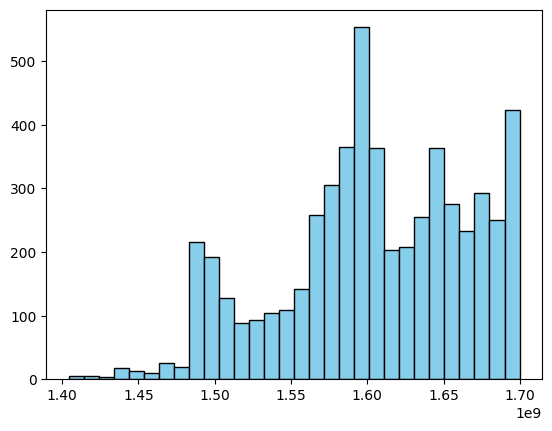

In [ ]:
counts, bins, patches = plt.hist(df['createdTime'], bins=30, color='skyblue', edgecolor='black')
start = bins[:-1]
end = bins[1:]
print(start, end, len(start))

In [ ]:
topic_modeling_30 = []

for i in range(len(start)):
    try:
        filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
        sentences = filtered_df['nouns'].astype(str)


        topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
        topics, probs = topic_model.fit_transform(sentences)

        freq = topic_model.get_topic_info(); freq.head(5)
        temp = {}
        temp['starting_idx'] = i
        temp['topics'] = topic_model.get_topic(0)
        topic_modeling_30.append(temp)  # Select the most frequent topic

    except:
        continue

print(topic_modeling_30)

In [ ]:
for i in range(len(topic_modeling_30)):
    print(topic_modeling_30[i])

{'starting_idx': 3, 'topics': False}
{'starting_idx': 4, 'topics': False}
{'starting_idx': 6, 'topics': False}
{'starting_idx': 7, 'topics': False}
{'starting_idx': 8, 'topics': [('game', 0.10528507287401218), ('elysium', 0.08690281304466292), ('gold', 0.06062241530173973), ('level', 0.05090451936903252), ('blind', 0.05090451936903252), ('dragon', 0.05090451936903252), ('power', 0.044881472039589046), ('roll20', 0.04051084788229913), ('fire', 0.04051084788229913), ('play', 0.04051084788229913)]}
{'starting_idx': 9, 'topics': [('anyone', 0.06952942686594472), ('game', 0.06513442430624426), ('dont', 0.0424201723566688), ('whats', 0.03895172943557389), ('people', 0.033580307798927865), ('world', 0.032629069103158), ('guys', 0.03140026293435066), ('rocketbook', 0.0287011271111586), ('cannon', 0.0287011271111586), ('palmer', 0.0287011271111586)]}
{'starting_idx': 10, 'topics': [('anyone', 0.059440849325854535), ('series', 0.04165575982063671), ('year', 0.03913076082699247), ('game', 0.03557

[1.40423740e+09 1.47811815e+09 1.55199889e+09 1.62587963e+09] [1.47811815e+09 1.55199889e+09 1.62587963e+09 1.69976038e+09] 4


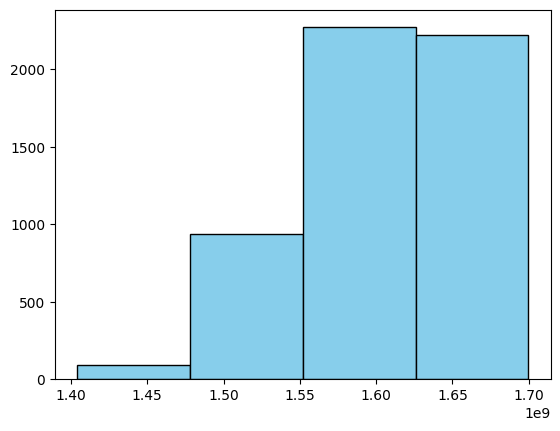

In [ ]:
counts, bins, patches = plt.hist(df['createdTime'], bins=4, color='skyblue', edgecolor='black')
start = bins[:-1]
end = bins[1:]
print(start, end, len(start))

In [ ]:
topic_modeling_4 = []

for i in range(len(start)):
    try:
        filtered_df = df[(df['createdTime'] >= start[i]) & (df['createdTime'] <= end[i])]
        sentences = filtered_df['nouns'].astype(str)


        topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
        topics, probs = topic_model.fit_transform(sentences)

        freq = topic_model.get_topic_info(); freq.head(5)
        temp = {}
        temp['starting_idx'] = i
        temp['topics'] = topic_model.get_topic(0)
        topic_modeling_4.append(temp)  # Select the most frequent topic

    except:
        continue

print(topic_modeling_4)

In [ ]:
for i in range(len(topic_modeling_4)):
    print(topic_modeling_4[i])

{'starting_idx': 0, 'topics': [('match', 0.10910049677035386), ('characters', 0.07629801369466108), ('anyone', 0.07036540803450993), ('joe', 0.06413393695922723), ('title', 0.06413393695922723), ('wrestling', 0.05110137942757552), ('beat', 0.05110137942757552), ('fire', 0.04810045271942042), ('games', 0.04577880821679665), ('elimination', 0.036894704365107236)]}
{'starting_idx': 1, 'topics': [('time', 0.04407686372375195), ('im', 0.04263165802848264), ('year', 0.034894482530372216), ('anyone', 0.03425137647626508), ('school', 0.031067911725401506), ('parents', 0.030452153847690334), ('people', 0.02856953898300134), ('home', 0.027283180857705563), ('dont', 0.026630008299756938), ('day', 0.024627710073920797)]}
{'starting_idx': 2, 'topics': [('time', 0.01963786212556298), ('im', 0.018131407562410513), ('years', 0.017079773418735855), ('life', 0.015844507384094625), ('parents', 0.015384384039339772), ('home', 0.015079835752804744), ('work', 0.014320974911604096), ('year', 0.01422442565453

#### topic model for emotion

In [ ]:
emotions = []

for i in range(len(df['emotion'][0][0])):
    emotions.append(df['emotion'][0][0][i]['label'])

In [ ]:
emotions

['love',
 'optimism',
 'desire',
 'neutral',
 'approval',
 'realization',
 'excitement',
 'joy',
 'disappointment',
 'caring',
 'confusion',
 'curiosity',
 'admiration',
 'surprise',
 'sadness',
 'disapproval',
 'remorse',
 'gratitude',
 'amusement',
 'annoyance',
 'fear',
 'anger',
 'disgust',
 'nervousness',
 'grief',
 'relief',
 'pride',
 'embarrassment']

In [ ]:
topic_modeling_emotion = pd.DataFrame(columns=['emotion','topics'])


for i in emotions:
    try:
        filtered_df = df[(df['top_emotion'] == i)]
        sentences = filtered_df['nouns'].astype(str)


        topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
        topics, probs = topic_model.fit_transform(sentences)

        # freq = topic_model.get_topic_info(); freq.head(5)

        # topic_modeling.append(topic_model.get_topic(0))  # Select the most frequent topic
        new_row = {'emotion': i, 'topics':topic_model.get_topic(0)}
        topic_modeling_emotion = topic_modeling_emotion.append(new_row, ignore_index=True)
    except:
        new_row = {'emotion': i, 'topics':'error'}
        topic_modeling_emotion = topic_modeling_emotion.append(new_row, ignore_index=True)



In [ ]:
topic_modeling_emotion

emotion                                             topics
0             love  [(love, 0.11004808903120815), (im, 0.082935540...
1         optimism                                              False
2           desire                                              False
3          neutral  [(wife, 0.04691545534452655), (morning, 0.0387...
4         approval                                              False
5      realization                                              False
6       excitement  [(im, 0.08079852811902068), (year, 0.059918253...
7              joy  [(time, 0.06372039667569661), (today, 0.063099...
8   disappointment  [(time, 0.06350825449469656), (im, 0.063092928...
9           caring                                              False
10       confusion                                              False
11       curiosity  [(anyone, 0.07357276601685349), (anybody, 0.04...
12      admiration  [(im, 0.04741869771422535), (hes, 0.0402742388...
13        surprise                                              False
14         sadness  [(time, 0.0952651358288151), (youre, 0.0644967...
15     disapproval                                              False
16         remorse                                              False
17       gratitude  [(im, 0.06286882367975787), (thanks, 0.0529421...
18       amusement  [(im, 0.059327499289897244), (people, 0.048491...
19       annoyance  [(anyone, 0.10176862753275859), (im, 0.0937739...
20            fear  [(time, 0.08172885049531216), (year, 0.0660478...
21           anger  [(people, 0.07620116314165758), (burger, 0.057...
22         disgust                                              False
23     nervousness                                              False
24           grief                                              error
25          relief                                              error
26           pride                                              error
27   embarrassment                                              error

In [ ]:
for i in range(len(topic_modeling_emotion)):
    print(topic_modeling_emotion['emotion'][i],'\n',topic_modeling_emotion['topics'][i],'\n\n')

In [ ]:
# topic_modeling_emotion.to_csv('/content/drive/Shareddrives/Fall23_NLPproject/data/topic_modeling_emotion.csv', index=False)

#### Topic modeling for each emotion by year

In [ ]:
def emotion_year_topic(emotion, df, min_gram, max_gram):
    filtered_df = df[(df['top_emotion'] == emotion)]

    filtered_df['time_column'] = pd.to_datetime(filtered_df['createdTime'], unit='s')

    # Extract year from the time_column
    filtered_df['year'] = filtered_df['time_column'].dt.year

    by_year = filtered_df.groupby('year').size()

    plt.figure(figsize=(12, 8))
    bars=by_year.plot(kind='bar', color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of data')
    plt.title(f'Number of data per Year, {emotion}')
    plt.xticks(rotation=45)
    x_labels = [int(label.get_text()) for label in bars.get_xticklabels()]
    # print(x_labels)
    for i, count in enumerate(by_year):

        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
        # print(type(i), i)
        sub_df =  filtered_df[(filtered_df['year'] == x_labels[i])]
        try:
            sentences = sub_df['nouns'].astype(str)
            sentences_array = sentences.to_numpy()

            topic_model = BERTopic(language="english", n_gram_range=(min_gram,max_gram), calculate_probabilities=True, verbose=True, low_memory=True)
            topics, probs = topic_model.fit_transform(sentences_array)

            topics = topic_model.get_topic(0)
            top_topic = topics[0][0]

            plt.text(i, 0.5, str(top_topic), ha='center')

        except:
            plt.text(i, 0.5, 'error', ha='center')
        # print(topics)


    plt.show()

admiration, love, curiosity - unigram

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:32:42,166 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:32:42,595 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 15:32:47,896 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:32:48,297 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:32:50,696 - BERTopic - Reduced dimensionality
2023-11-26 15:32:50,706 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:32:51,291 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:32:54,924 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:32:55,473 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:32:57,487 - BERTopic - Reduced dimensionality
2023-11-26 15:32:57,492 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-26 15:32:57,994 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:32:59,875 - BERTopic - Reduced dimensionality
2023-11-26 15:32:59,884 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:33:00,409 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:02,288 - BERTopic - Reduced dimensionality
2023-11-26 15:33:02,296 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-26 15:33:02,706 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:05,191 - BERTopic - Reduced dimensionality
2023-11-26 15:33:05,201 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:33:05,634 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:08,543 - BERTopic - Reduced dimensionality
2023-11-26 15:33:08,549 - BERTopic - Clustered reduced embeddings


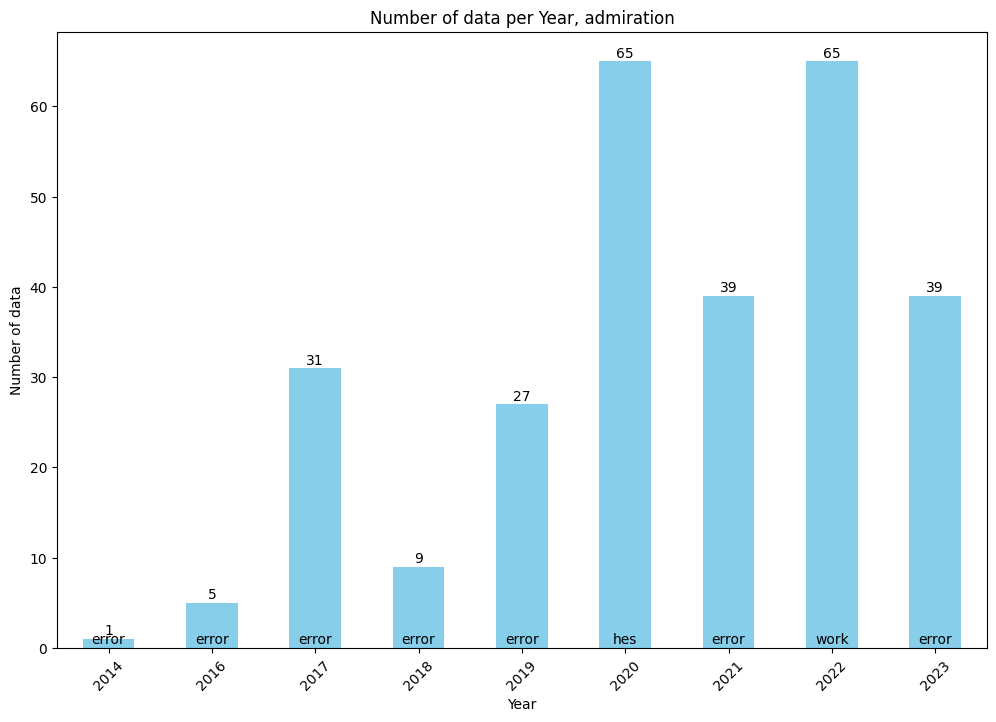

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:09,448 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:10,030 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:12,821 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:13,182 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 15:33:13,198 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:13,691 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:15,597 - BERTopic - Reduced dimensionality
2023-11-26 15:33:15,604 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-26 15:33:16,168 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:18,741 - BERTopic - Reduced dimensionality
2023-11-26 15:33:18,752 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:19,225 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:21,107 - BERTopic - Reduced dimensionality
2023-11-26 15:33:21,112 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:33:21,624 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:24,054 - BERTopic - Reduced dimensionality
2023-11-26 15:33:24,062 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:33:24,799 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:27,918 - BERTopic - Reduced dimensionality
2023-11-26 15:33:27,926 - BERTopic - Clustered reduced embeddings


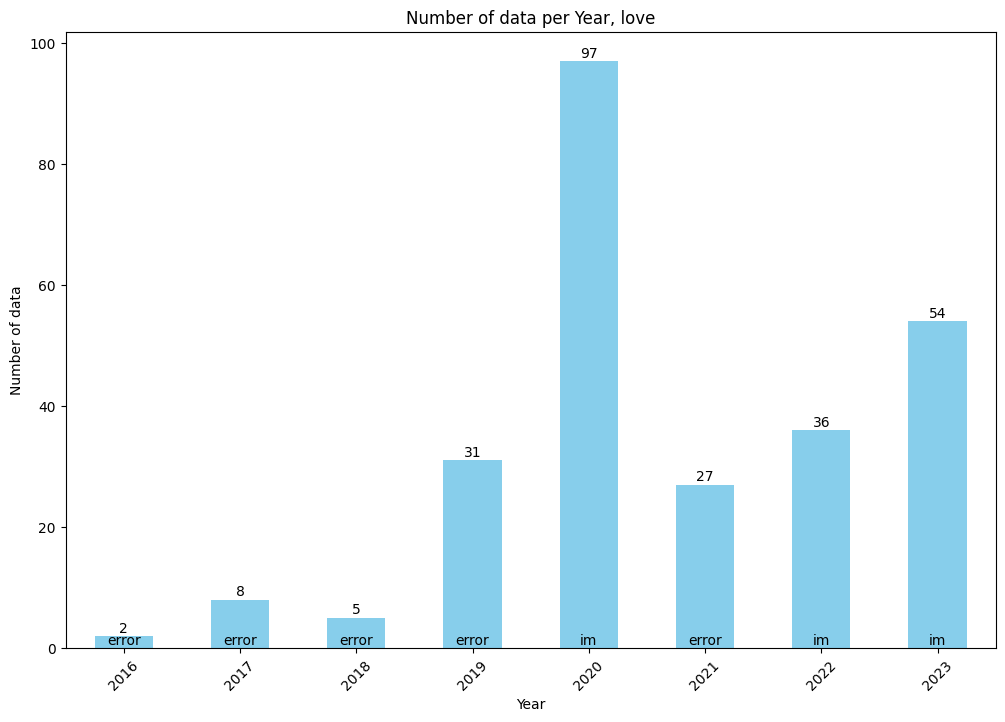

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:28,805 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:29,278 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:29,674 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:31,598 - BERTopic - Reduced dimensionality
2023-11-26 15:33:31,602 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:31,991 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:34,483 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:34,898 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:36,758 - BERTopic - Reduced dimensionality
2023-11-26 15:33:36,764 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:33:37,179 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:39,089 - BERTopic - Reduced dimensionality
2023-11-26 15:33:39,098 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:39,704 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:42,707 - BERTopic - Reduced dimensionality
2023-11-26 15:33:42,717 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:43,341 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:46,085 - BERTopic - Reduced dimensionality
2023-11-26 15:33:46,094 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:33:47,131 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:33:49,007 - BERTopic - Reduced dimensionality
2023-11-26 15:33:49,012 - BERTopic - Clustered reduced embeddings


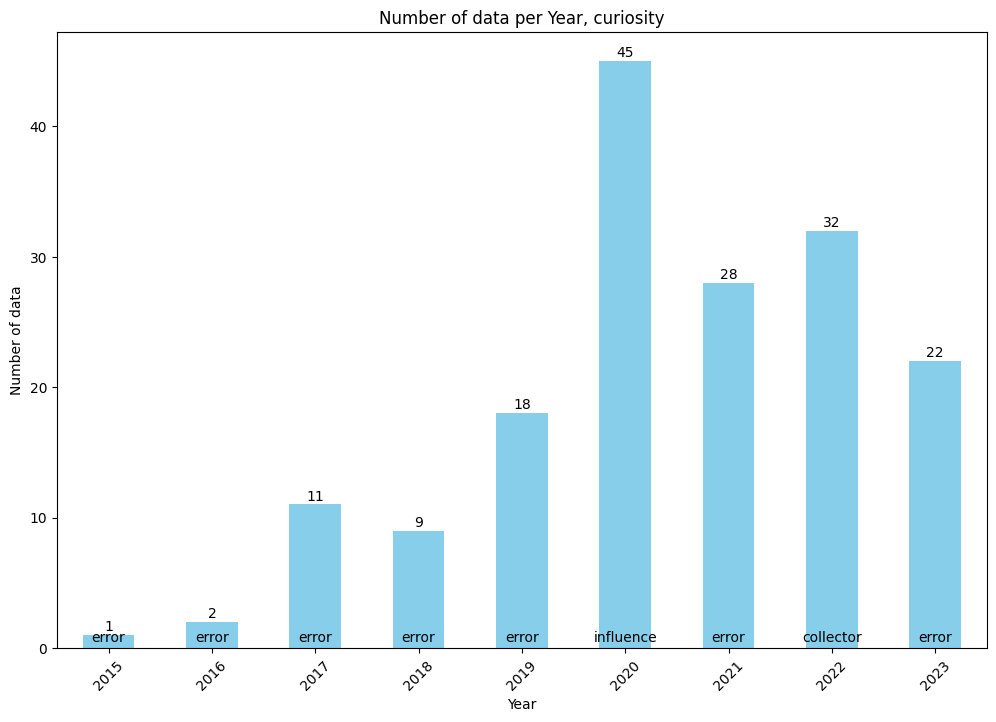

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_topic(e, df, 1, 1)

Topic modeling for each emotion (top 3) by year - bigram

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:35:50,709 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:35:51,067 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 15:35:51,078 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:35:51,497 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:35:53,361 - BERTopic - Reduced dimensionality
2023-11-26 15:35:53,367 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:35:53,750 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:35:55,589 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:35:55,973 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:35:57,806 - BERTopic - Reduced dimensionality
2023-11-26 15:35:57,811 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-26 15:35:58,310 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:01,710 - BERTopic - Reduced dimensionality
2023-11-26 15:36:01,724 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:36:03,013 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:11,958 - BERTopic - Reduced dimensionality
2023-11-26 15:36:11,972 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-26 15:36:13,655 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:20,624 - BERTopic - Reduced dimensionality
2023-11-26 15:36:20,640 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:36:22,173 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:26,275 - BERTopic - Reduced dimensionality
2023-11-26 15:36:26,283 - BERTopic - Clustered reduced embeddings


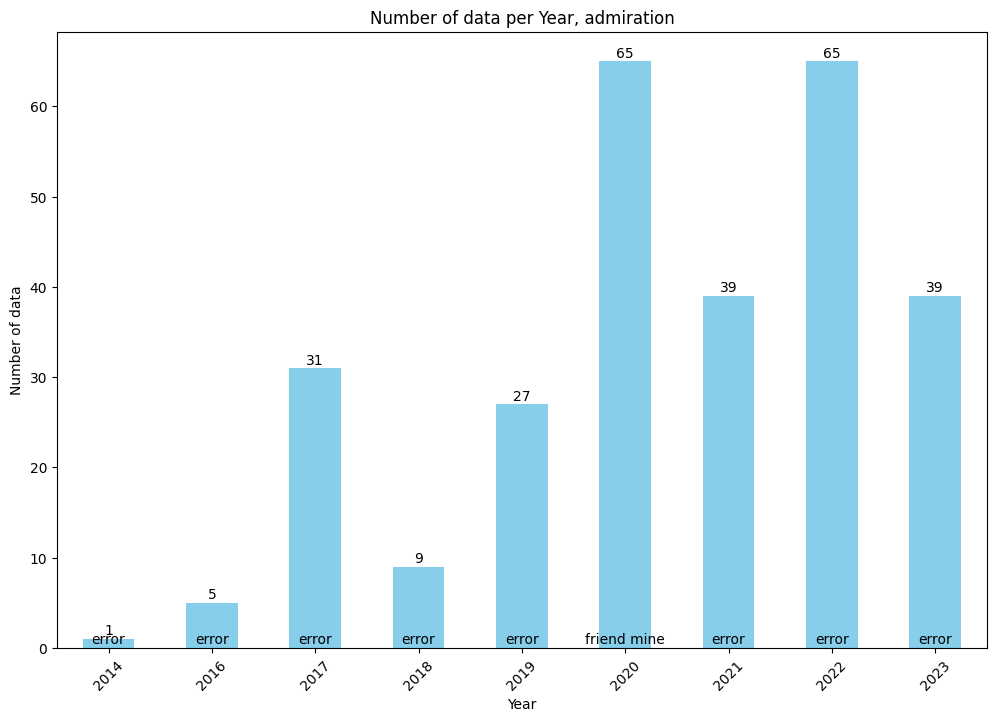

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:27,262 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:27,866 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:30,957 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:31,520 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 15:36:31,536 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:32,219 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:40,129 - BERTopic - Reduced dimensionality
2023-11-26 15:36:40,136 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-26 15:36:40,890 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:42,905 - BERTopic - Reduced dimensionality
2023-11-26 15:36:42,915 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:43,450 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:46,128 - BERTopic - Reduced dimensionality
2023-11-26 15:36:46,138 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:36:46,895 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:50,060 - BERTopic - Reduced dimensionality
2023-11-26 15:36:50,068 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:36:50,819 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:36:57,728 - BERTopic - Reduced dimensionality
2023-11-26 15:36:57,750 - BERTopic - Clustered reduced embeddings


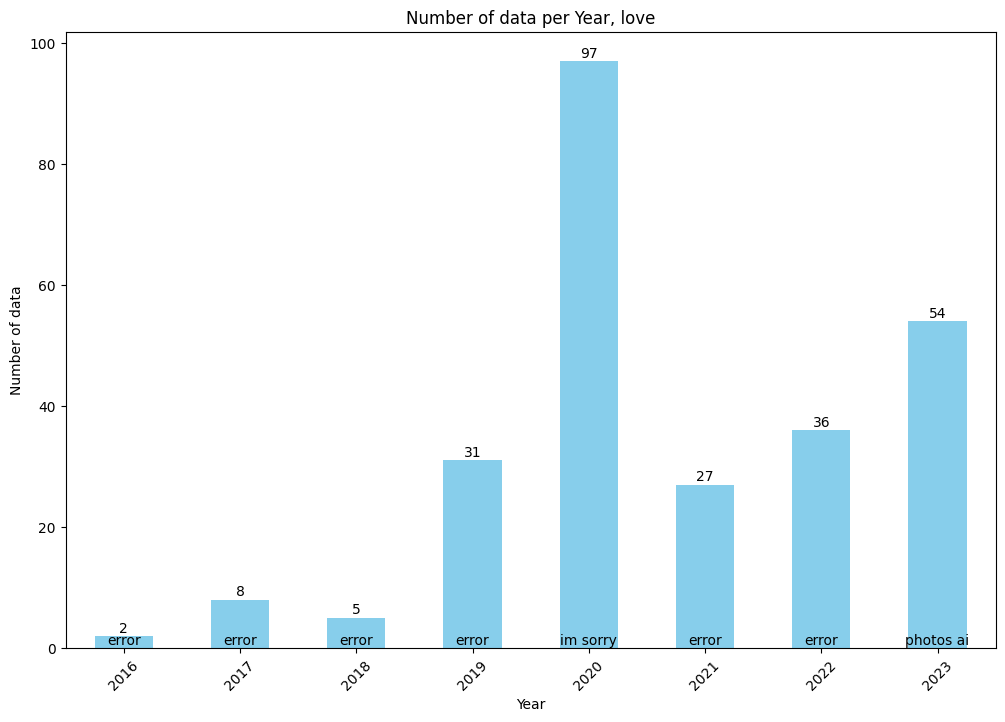

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:58,970 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:36:59,557 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:37:00,126 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:03,602 - BERTopic - Reduced dimensionality
2023-11-26 15:37:03,612 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:37:04,538 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:12,461 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:37:13,583 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:17,646 - BERTopic - Reduced dimensionality
2023-11-26 15:37:17,664 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:37:18,312 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:21,631 - BERTopic - Reduced dimensionality
2023-11-26 15:37:21,646 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:37:22,351 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:24,851 - BERTopic - Reduced dimensionality
2023-11-26 15:37:24,858 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:37:25,318 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:28,176 - BERTopic - Reduced dimensionality
2023-11-26 15:37:28,185 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:37:28,801 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:37:31,851 - BERTopic - Reduced dimensionality
2023-11-26 15:37:31,857 - BERTopic - Clustered reduced embeddings


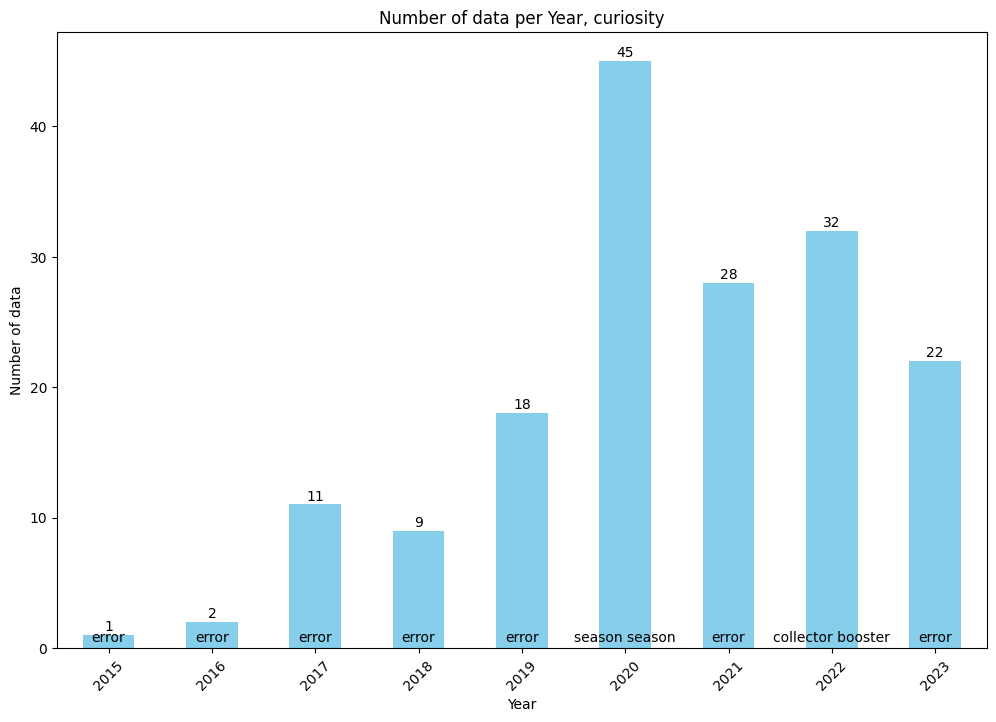

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_topic(e,df, 2,2)

Topic modeling for each emotion (top 3) by year - trigrams

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:38:42,744 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:38:43,274 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 15:38:43,285 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:38:43,860 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:38:46,655 - BERTopic - Reduced dimensionality
2023-11-26 15:38:46,662 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:38:47,039 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:38:48,839 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:38:49,544 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:38:53,598 - BERTopic - Reduced dimensionality
2023-11-26 15:38:53,603 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-26 15:38:54,113 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:38:56,023 - BERTopic - Reduced dimensionality
2023-11-26 15:38:56,035 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:38:56,553 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:38:59,610 - BERTopic - Reduced dimensionality
2023-11-26 15:38:59,618 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-26 15:39:00,229 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:03,273 - BERTopic - Reduced dimensionality
2023-11-26 15:39:03,280 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:39:03,733 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:05,588 - BERTopic - Reduced dimensionality
2023-11-26 15:39:05,594 - BERTopic - Clustered reduced embeddings


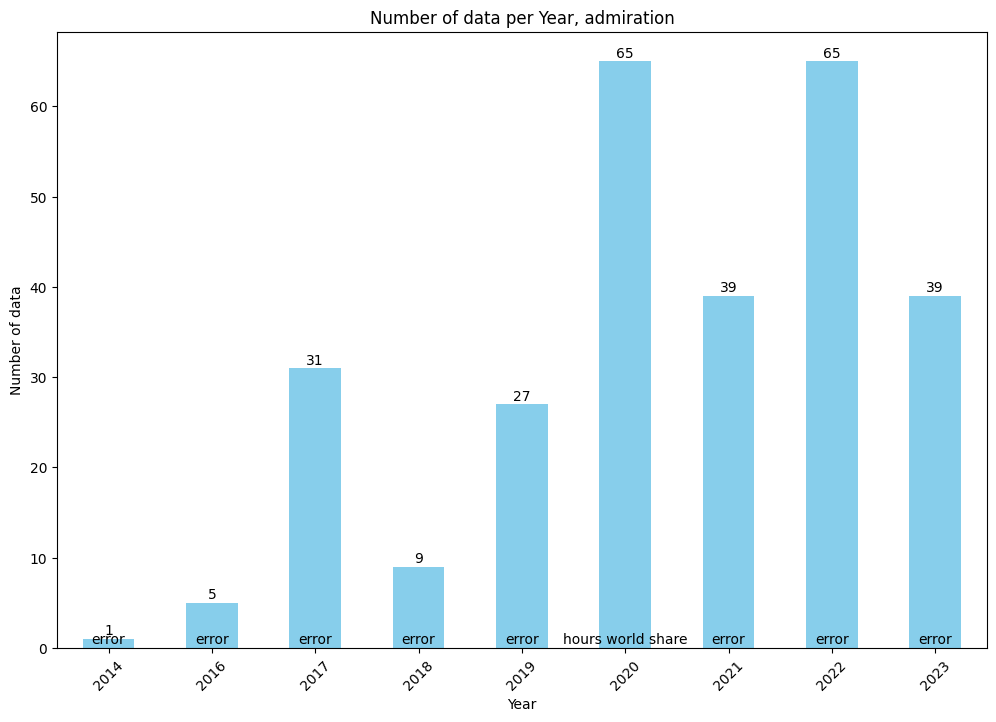

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:06,217 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:06,616 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:09,203 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:09,582 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 15:39:09,593 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:10,075 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:11,968 - BERTopic - Reduced dimensionality
2023-11-26 15:39:11,975 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-26 15:39:12,565 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:15,404 - BERTopic - Reduced dimensionality
2023-11-26 15:39:15,422 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:16,087 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:19,118 - BERTopic - Reduced dimensionality
2023-11-26 15:39:19,123 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:39:19,774 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:21,605 - BERTopic - Reduced dimensionality
2023-11-26 15:39:21,611 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:39:22,139 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:24,668 - BERTopic - Reduced dimensionality
2023-11-26 15:39:24,677 - BERTopic - Clustered reduced embeddings


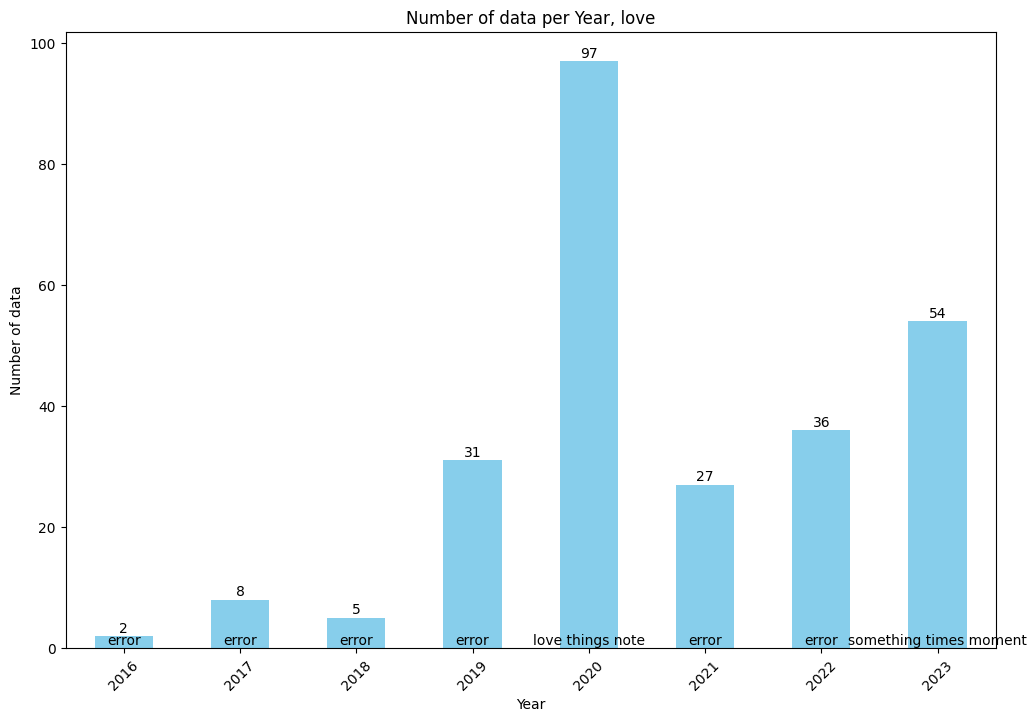

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:25,314 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:25,685 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:26,072 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:27,964 - BERTopic - Reduced dimensionality
2023-11-26 15:39:27,969 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:28,413 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:30,723 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:31,297 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:34,232 - BERTopic - Reduced dimensionality
2023-11-26 15:39:34,238 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-26 15:39:34,821 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:37,866 - BERTopic - Reduced dimensionality
2023-11-26 15:39:37,875 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:38,325 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:40,180 - BERTopic - Reduced dimensionality
2023-11-26 15:39:40,186 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:40,646 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:42,511 - BERTopic - Reduced dimensionality
2023-11-26 15:39:42,519 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 15:39:42,946 - BERTopic - Transformed documents to Embeddings
2023-11-26 15:39:44,774 - BERTopic - Reduced dimensionality
2023-11-26 15:39:44,779 - BERTopic - Clustered reduced embeddings


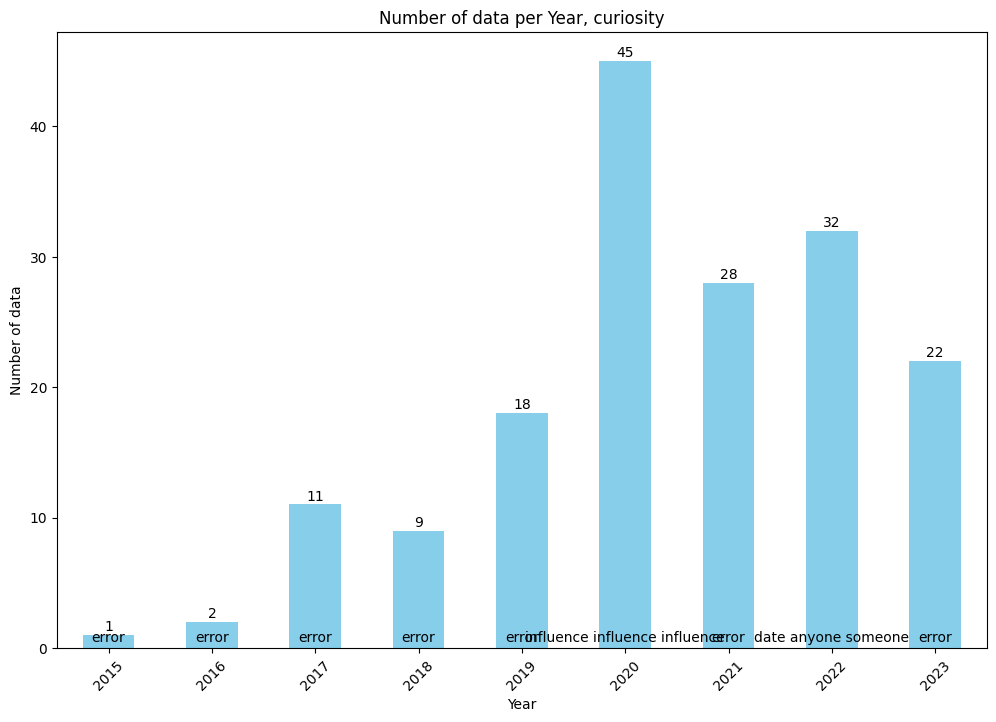

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_topic(e,df,3,3)

consider all (uni to tri)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:40:46,185 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:40:46,550 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 02:40:46,561 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:40:46,989 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:40:49,364 - BERTopic - Reduced dimensionality
2023-11-22 02:40:49,376 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:40:49,970 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:40:53,819 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:40:54,417 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:40:56,422 - BERTopic - Reduced dimensionality
2023-11-22 02:40:56,428 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-22 02:40:56,932 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:40:58,876 - BERTopic - Reduced dimensionality
2023-11-22 02:40:58,886 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-22 02:40:59,409 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:03,280 - BERTopic - Reduced dimensionality
2023-11-22 02:41:03,287 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-22 02:41:04,282 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:11,660 - BERTopic - Reduced dimensionality
2023-11-22 02:41:11,674 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-22 02:41:13,116 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:18,043 - BERTopic - Reduced dimensionality
2023-11-22 02:41:18,055 - BERTopic - Clustered reduced embeddings


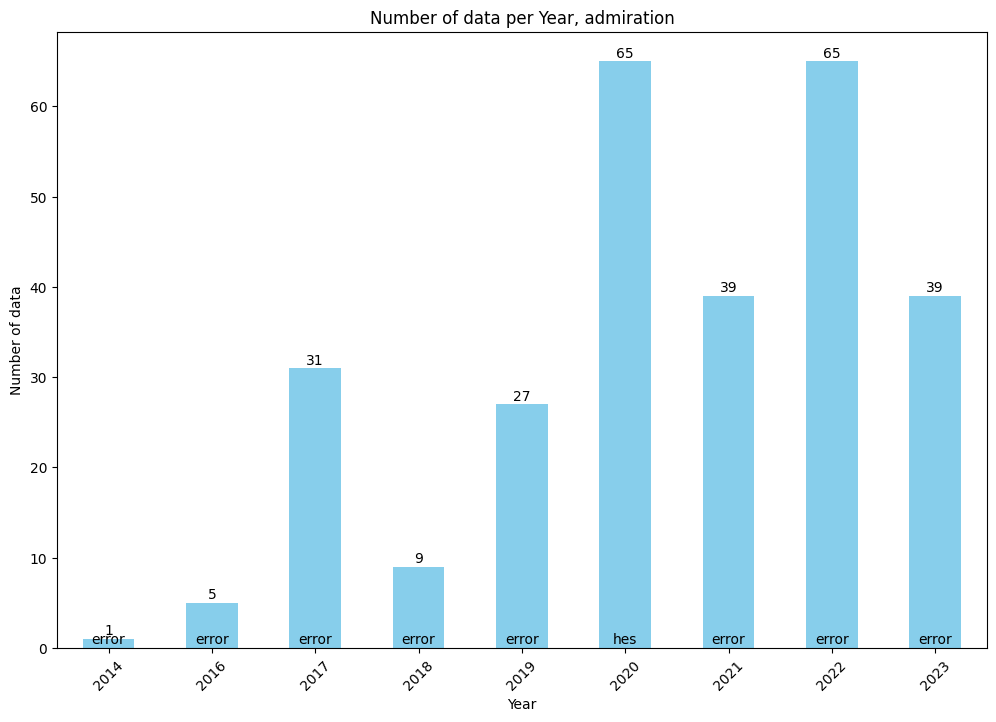

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:19,039 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:19,640 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:23,098 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:24,033 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 02:41:24,054 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:25,310 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:30,536 - BERTopic - Reduced dimensionality
2023-11-22 02:41:30,544 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-22 02:41:31,128 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:33,207 - BERTopic - Reduced dimensionality
2023-11-22 02:41:33,218 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:33,750 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:35,659 - BERTopic - Reduced dimensionality
2023-11-22 02:41:35,666 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-22 02:41:36,181 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:38,807 - BERTopic - Reduced dimensionality
2023-11-22 02:41:38,818 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-22 02:41:39,366 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:42,165 - BERTopic - Reduced dimensionality
2023-11-22 02:41:42,174 - BERTopic - Clustered reduced embeddings


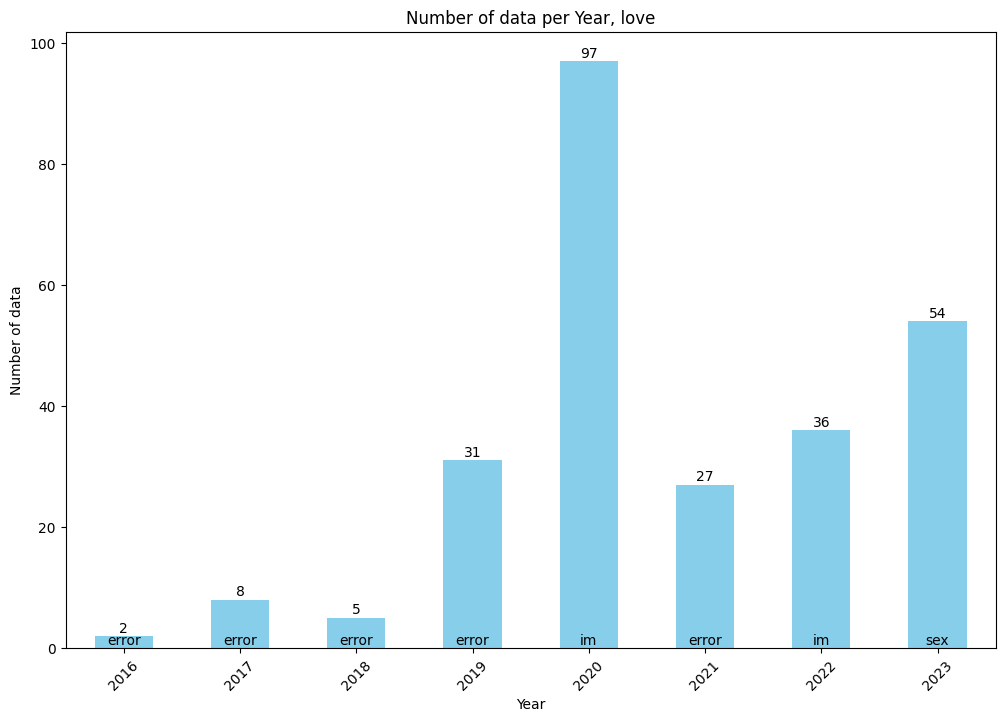

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:43,178 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:43,726 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:44,273 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:47,129 - BERTopic - Reduced dimensionality
2023-11-22 02:41:47,134 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:47,542 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:49,399 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:49,827 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:51,680 - BERTopic - Reduced dimensionality
2023-11-22 02:41:51,686 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-22 02:41:52,127 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:54,773 - BERTopic - Reduced dimensionality
2023-11-22 02:41:54,781 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:55,237 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:41:58,232 - BERTopic - Reduced dimensionality
2023-11-22 02:41:58,242 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:41:58,918 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:42:02,551 - BERTopic - Reduced dimensionality
2023-11-22 02:42:02,561 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 02:42:03,282 - BERTopic - Transformed documents to Embeddings
2023-11-22 02:42:06,698 - BERTopic - Reduced dimensionality
2023-11-22 02:42:06,709 - BERTopic - Clustered reduced embeddings


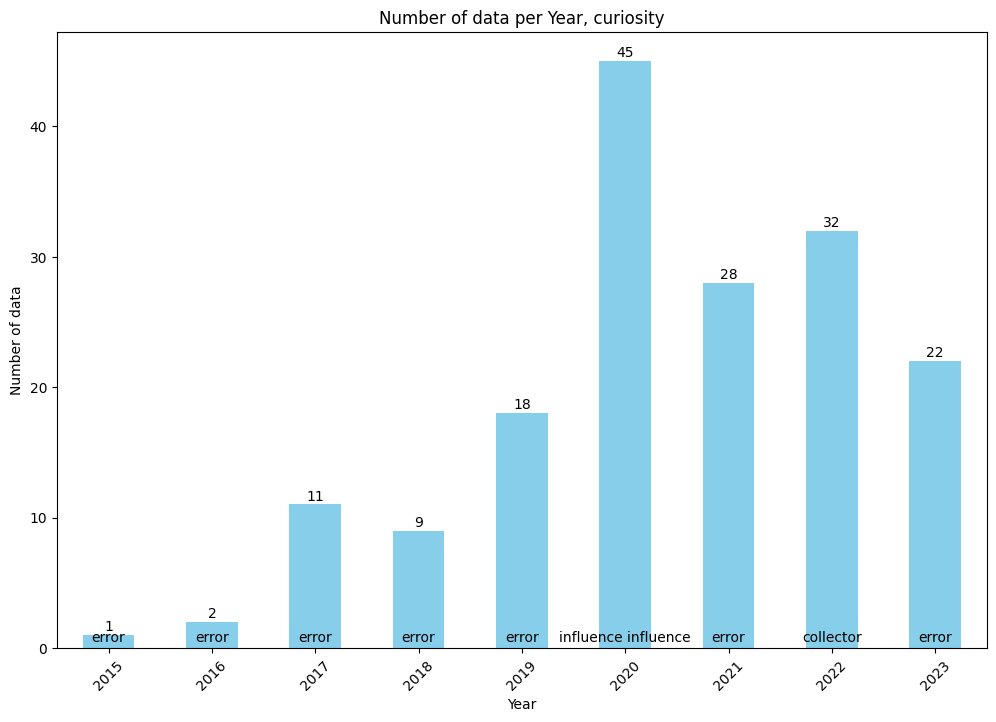

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_topic(e,df,1,3)

#### Topic modeling with LDA

In [ ]:


def emotion_year_lda(emotion, df):
    filtered_df = df[(df['top_emotion'] == emotion)]

    filtered_df['time_column'] = pd.to_datetime(filtered_df['createdTime'], unit='s')

    # Extract year from the time_column
    filtered_df['year'] = filtered_df['time_column'].dt.year

    by_year = filtered_df.groupby('year').size()

    plt.figure(figsize=(12, 8))
    bars=by_year.plot(kind='bar', color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of data')
    plt.title(f'Number of data per Year, {emotion}')
    plt.xticks(rotation=45)
    x_labels = [int(label.get_text()) for label in bars.get_xticklabels()]
    # print(x_labels)
    for i, count in enumerate(by_year):

        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
        # print(type(i), i)
        sub_df =  filtered_df[(filtered_df['year'] == x_labels[i])]
        try:
            sentences = sub_df['nouns'].astype(str)
            sentences = sentences.str.replace('[','')
            sentences = sentences.str.replace(']','')
            sentences = sentences.str.replace("'",'')
            sentences = sentences.str.replace(',','')
            all_sentences = []
            for k in sentences:
                all_sentences.append(word_tokenize(k))

            dictionary = Dictionary(all_sentences)
            corpus = [dictionary.doc2bow(sentence) for sentence in all_sentences]
            combined_corpus = sum(corpus, [])


            lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, iterations=100, passes=10)
            id2word = dictionary

            topic_distribution = lda_model.get_document_topics([combined_corpus])
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            dominant_topic_word = id2word[dominant_topic[0]]
            plt.text(i, 0.5, str(dominant_topic_word), ha='center')

        except:
            plt.text(i, 0.5, 'error', ha='center')
        # print(topics)


    plt.show()

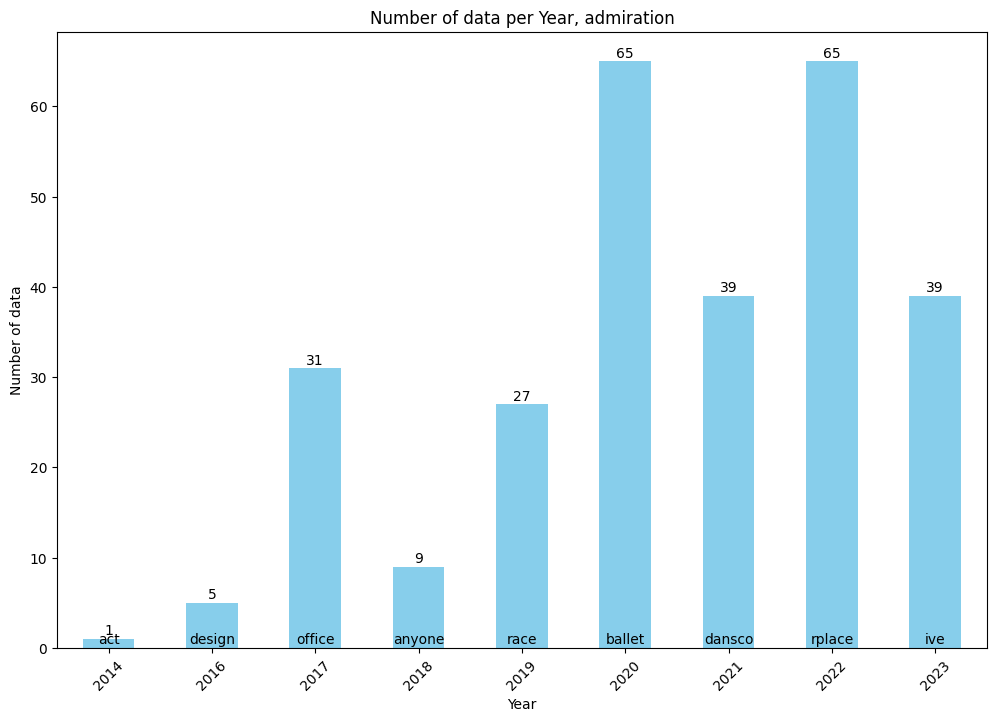

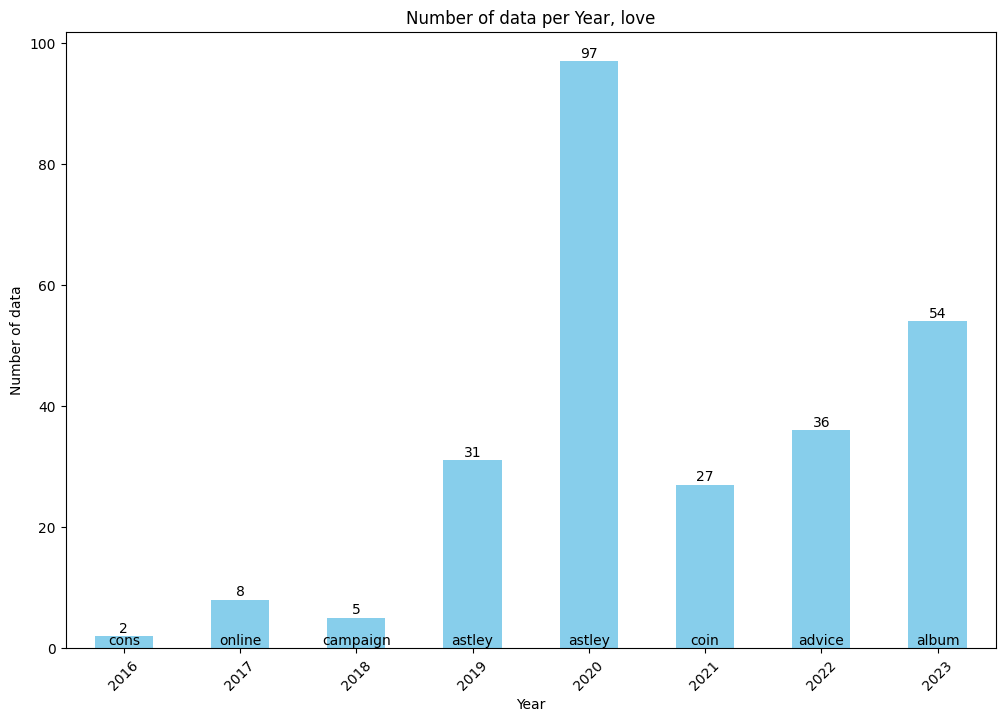

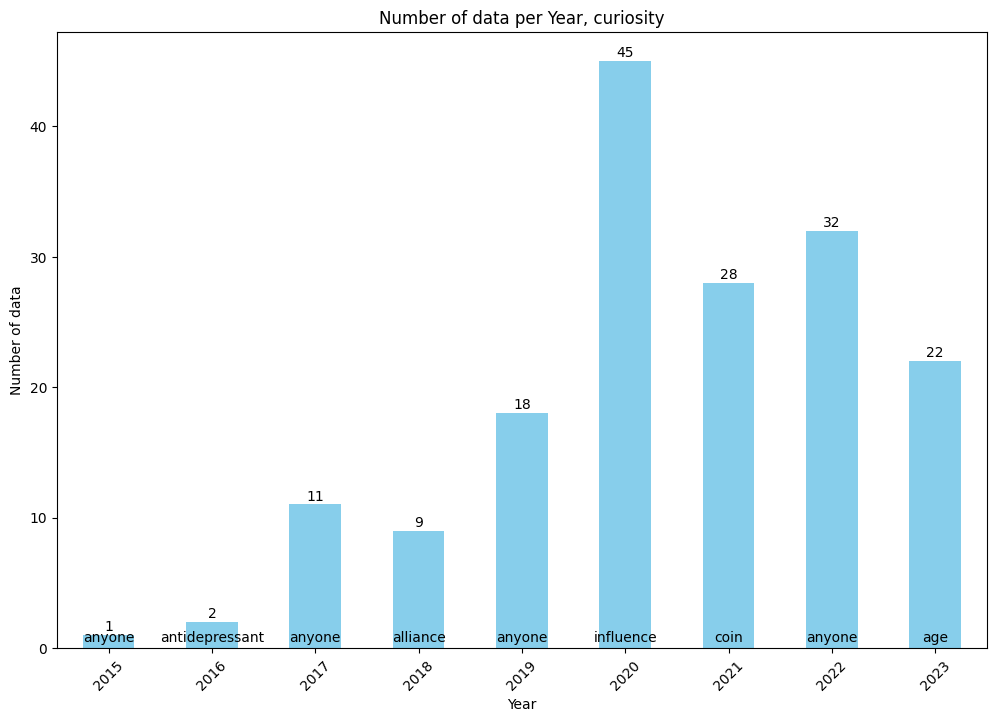

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_lda(e,df)

##### LDA topic modeling bigram

In [ ]:


def emotion_year_lda_bigram(emotion, df):
    filtered_df = df[(df['top_emotion'] == emotion)]

    filtered_df['time_column'] = pd.to_datetime(filtered_df['createdTime'], unit='s')

    # Extract year from the time_column
    filtered_df['year'] = filtered_df['time_column'].dt.year

    by_year = filtered_df.groupby('year').size()

    plt.figure(figsize=(12, 8))
    bars=by_year.plot(kind='bar', color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of data')
    plt.title(f'Number of data per Year, {emotion}')
    plt.xticks(rotation=45)
    x_labels = [int(label.get_text()) for label in bars.get_xticklabels()]
    # print(x_labels)
    for i, count in enumerate(by_year):

        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
        # print(type(i), i)
        sub_df =  filtered_df[(filtered_df['year'] == x_labels[i])]
        try:
            sentences = sub_df['nouns'].astype(str)
            sentences = sentences.str.replace('[','')
            sentences = sentences.str.replace(']','')
            sentences = sentences.str.replace("'",'')
            sentences = sentences.str.replace(',','')


            # Preprocess the corpus by concatenating bigrams
            bigrams = []
            for doc in sentences:
                bigrams.extend(ngrams(word_tokenize(doc), 2))

            vocabulary = set(list(word_tokenize(sentences[0])) + bigrams)

            preprocessed_sentences = []
            for doc in sentences:
                new_doc = []
                for word in word_tokenize(doc):
                    if word in vocabulary:
                        new_doc.append(word)
                    elif len(word.split()) == 2 and word.split()[0] in vocabulary and word.split()[1] in vocabulary:
                        new_doc.append("_".join(word.split()))
                preprocessed_sentences.append(new_doc)


            dictionary = Dictionary(preprocessed_sentences)
            corpus = [dictionary.doc2bow(sentence) for sentence in preprocessed_sentences]
            combined_corpus = sum(corpus, [])


            lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, iterations=100, passes=10)
            id2word = dictionary

            topic_distribution = lda_model.get_document_topics([combined_corpus])
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            dominant_topic_word = id2word[dominant_topic[0]]
            plt.text(i, 0.5, str(dominant_topic_word), ha='center')

        except:
            plt.text(i, 0.5, 'error', ha='center')
        # print(topics)


    plt.show()

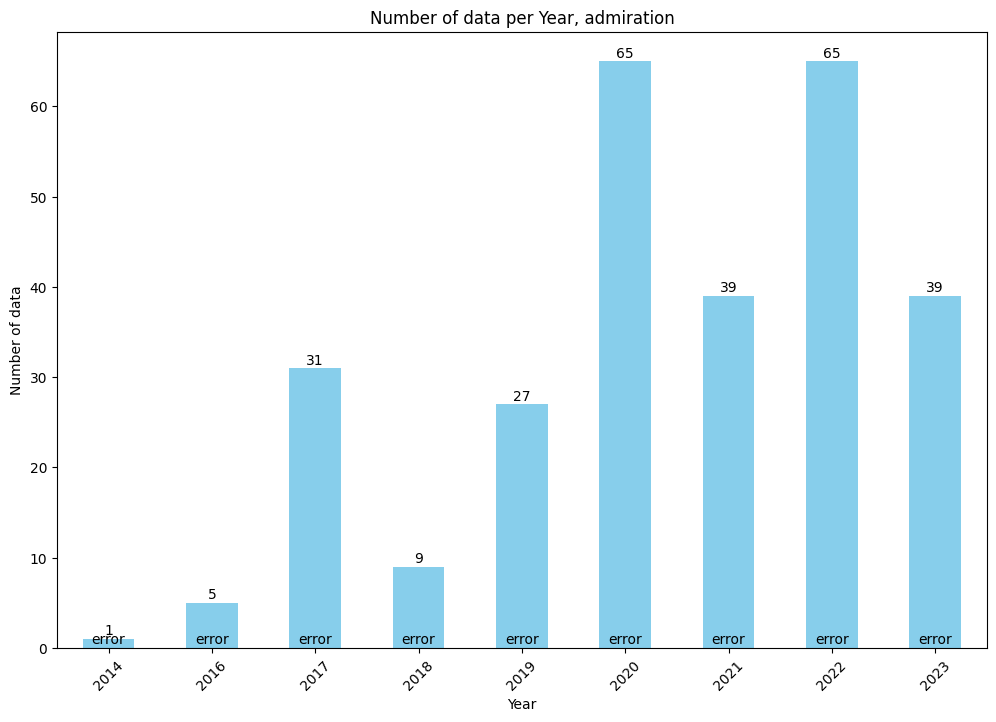

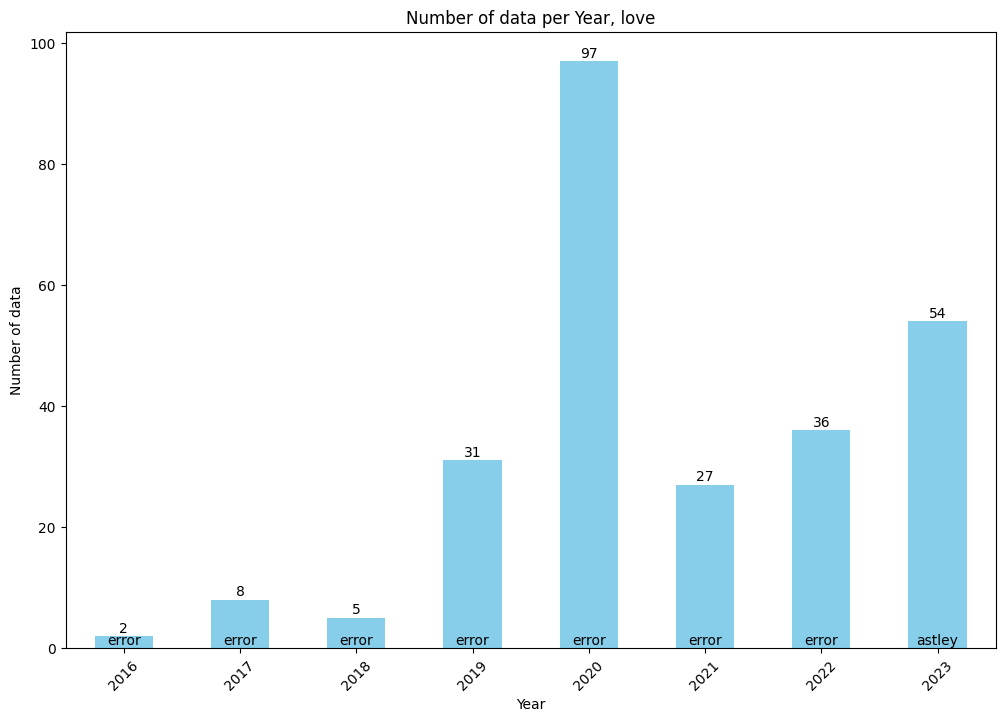

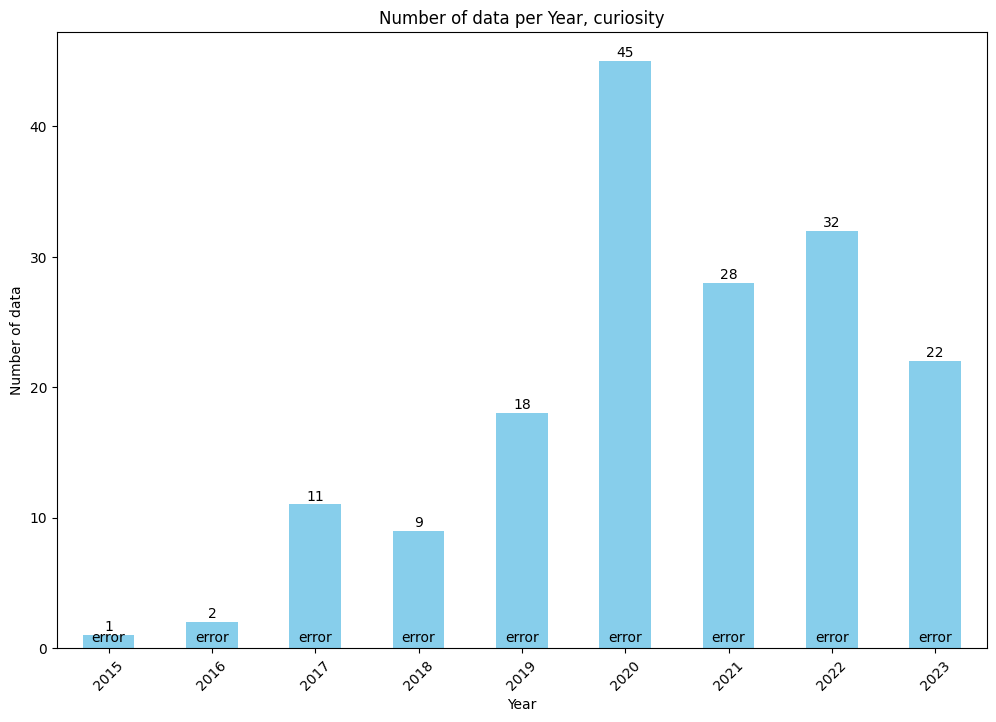

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_lda_bigram(e,df)

##### lda trigram

In [ ]:
def emotion_year_lda_tri(emotion, df):
    filtered_df = df[(df['top_emotion'] == emotion)]

    filtered_df['time_column'] = pd.to_datetime(filtered_df['createdTime'], unit='s')

    # Extract year from the time_column
    filtered_df['year'] = filtered_df['time_column'].dt.year

    by_year = filtered_df.groupby('year').size()

    plt.figure(figsize=(12, 8))
    bars=by_year.plot(kind='bar', color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of data')
    plt.title(f'Number of data per Year, {emotion}')
    plt.xticks(rotation=45)
    x_labels = [int(label.get_text()) for label in bars.get_xticklabels()]
    # print(x_labels)
    for i, count in enumerate(by_year):

        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
        # print(type(i), i)
        sub_df =  filtered_df[(filtered_df['year'] == x_labels[i])]
        try:
            sentences = sub_df['nouns'].astype(str)
            sentences = sentences.str.replace('[','')
            sentences = sentences.str.replace(']','')
            sentences = sentences.str.replace("'",'')
            sentences = sentences.str.replace(',','')

            # Preprocess the corpus by concatenating trigrams
            trigrams = []
            for doc in sentences:
                trigrams.extend(ngrams(word_tokenize(doc), 3))

            vocabulary = set(list(word_tokenize(sentences[0])) + trigrams)

            preprocessed_sentences = []
            for doc in sentences:
                new_doc = []
                for word in word_tokenize(doc):
                    if word in vocabulary:
                        new_doc.append(word)
                    elif len(word.split()) == 3 and word.split()[0] in vocabulary and word.split()[1] in vocabulary and word.split()[2] in vocabulary:
                        new_doc.append("_".join(word.split()))
                preprocessed_sentences.append(new_doc)


            dictionary = corpora.Dictionary(preprocessed_sentences)
            corpus = [dictionary.doc2bow(sentence) for sentence in preprocessed_sentences]
            combined_corpus = sum(corpus, [])

            lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, iterations=100, passes=10)
            id2word = dictionary

            topic_distribution = lda_model.get_document_topics([combined_corpus])
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            dominant_topic_word = id2word[dominant_topic[0]]
            plt.text(i, 0.5, str(dominant_topic_word), ha='center')

        except:
            plt.text(i, 0.5, 'error', ha='center')
        # print(topics)


    plt.show()


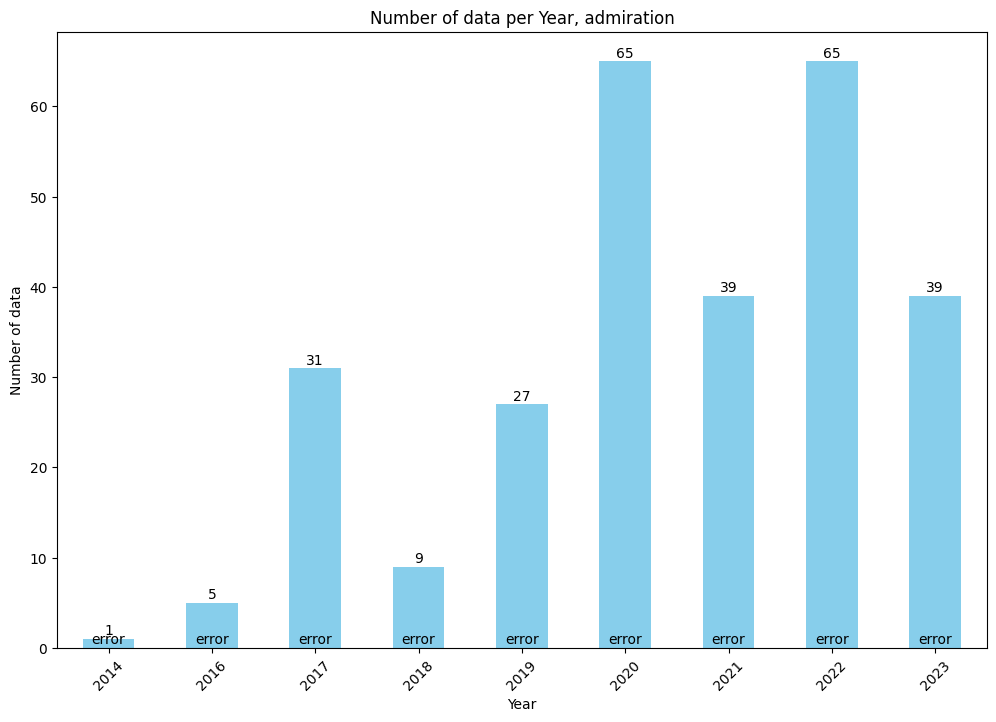

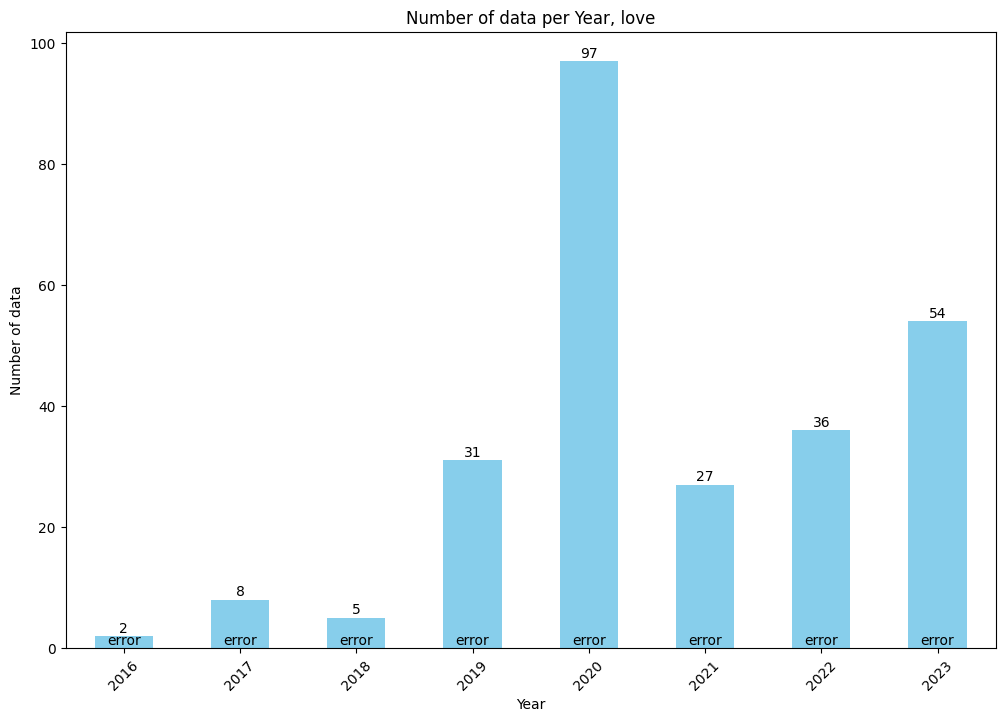

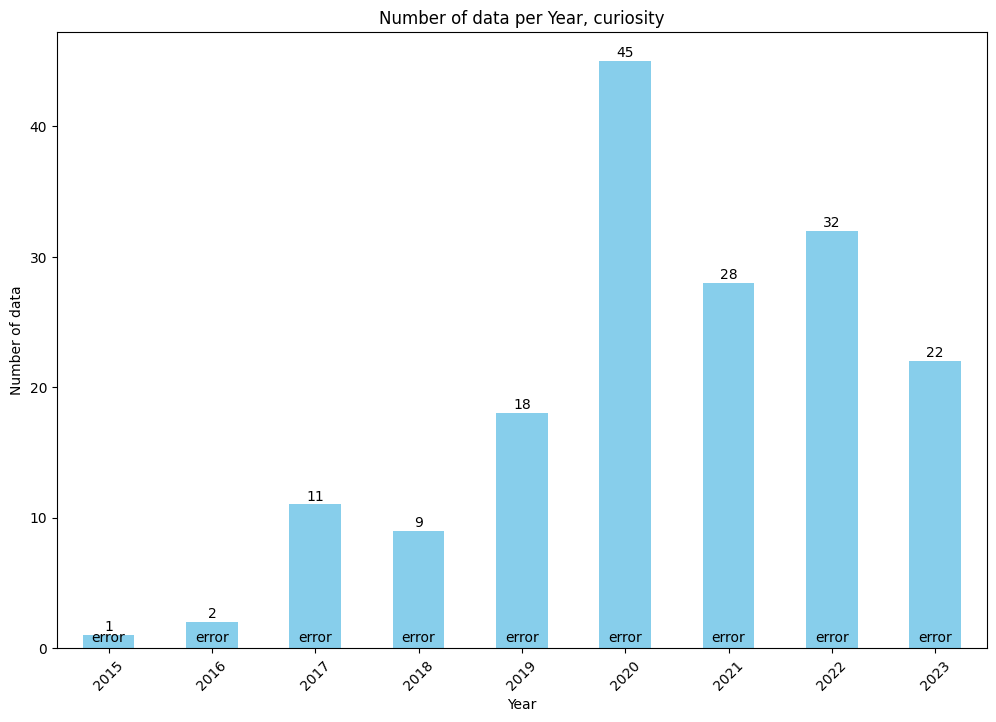

In [ ]:
emotion = ['admiration','love','curiosity']
for e in emotion:
    emotion_year_lda_tri(e,df)

#### test

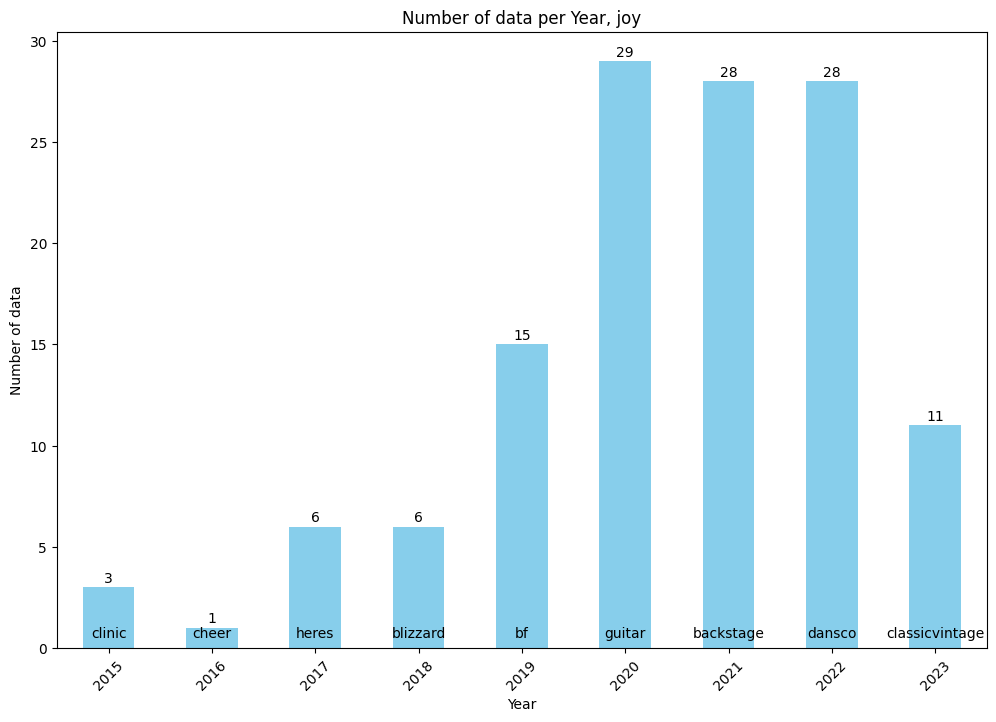

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:08:34,266 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 04:08:45,060 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:08:45,515 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:08:46,195 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 04:08:46,219 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:08:47,117 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 04:08:47,134 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:08:50,530 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:08:54,550 - BERTopic - Reduced dimensionality
2023-11-22 04:08:54,586 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:01,213 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:09:03,669 - BERTopic - Reduced dimensionality
2023-11-22 04:09:03,676 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:10,195 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:09:14,213 - BERTopic - Reduced dimensionality
2023-11-22 04:09:14,225 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:20,059 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:09:23,581 - BERTopic - Reduced dimensionality
2023-11-22 04:09:23,589 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:25,376 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:09:29,333 - BERTopic - Reduced dimensionality
2023-11-22 04:09:29,341 - BERTopic - Clustered reduced embeddings


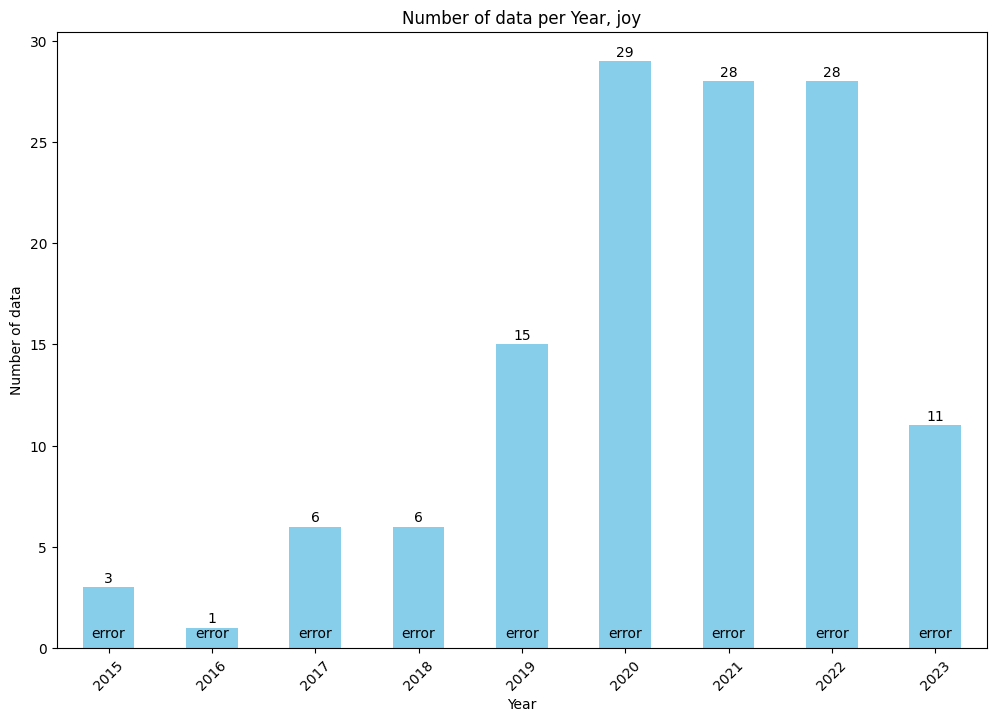

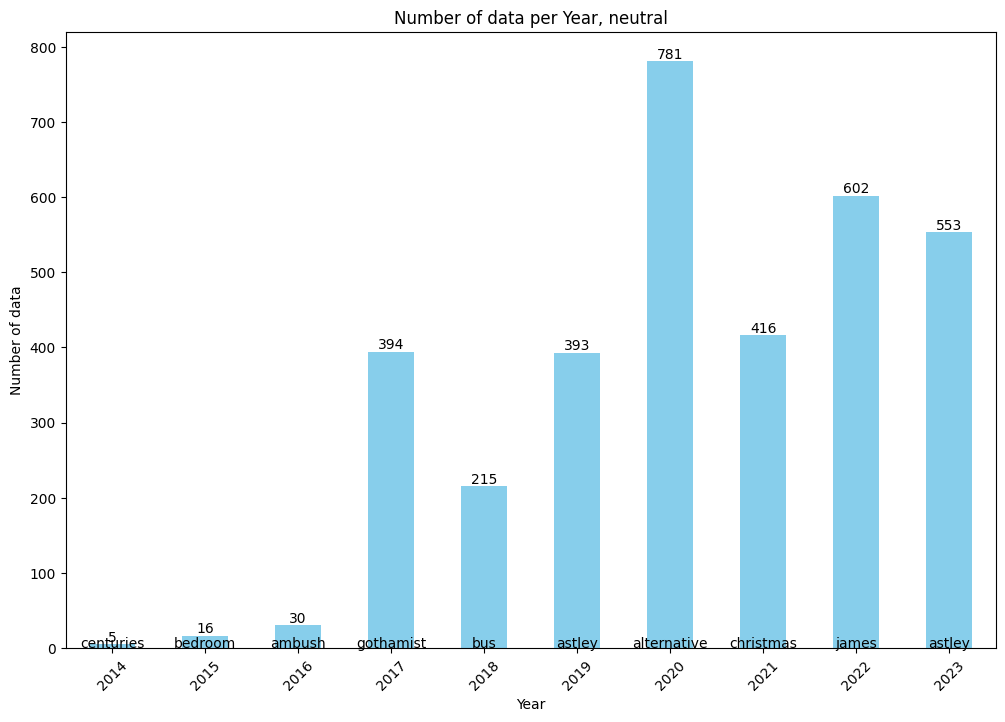

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:47,128 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 04:09:47,146 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:49,094 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:09:52,509 - BERTopic - Reduced dimensionality
2023-11-22 04:09:52,516 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:09:58,638 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:10:01,211 - BERTopic - Reduced dimensionality
2023-11-22 04:10:01,219 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2023-11-22 04:10:16,009 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:10:22,638 - BERTopic - Reduced dimensionality
2023-11-22 04:10:22,718 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2023-11-22 04:10:37,706 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:10:40,546 - BERTopic - Reduced dimensionality
2023-11-22 04:10:40,566 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2023-11-22 04:10:55,908 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:10:59,110 - BERTopic - Reduced dimensionality
2023-11-22 04:10:59,139 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2023-11-22 04:11:21,693 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:11:28,882 - BERTopic - Reduced dimensionality
2023-11-22 04:11:28,968 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2023-11-22 04:11:43,779 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:11:48,668 - BERTopic - Reduced dimensionality
2023-11-22 04:11:48,705 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

2023-11-22 04:12:08,257 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:12:13,209 - BERTopic - Reduced dimensionality
2023-11-22 04:12:13,253 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2023-11-22 04:12:40,534 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:12:45,544 - BERTopic - Reduced dimensionality
2023-11-22 04:12:45,583 - BERTopic - Clustered reduced embeddings


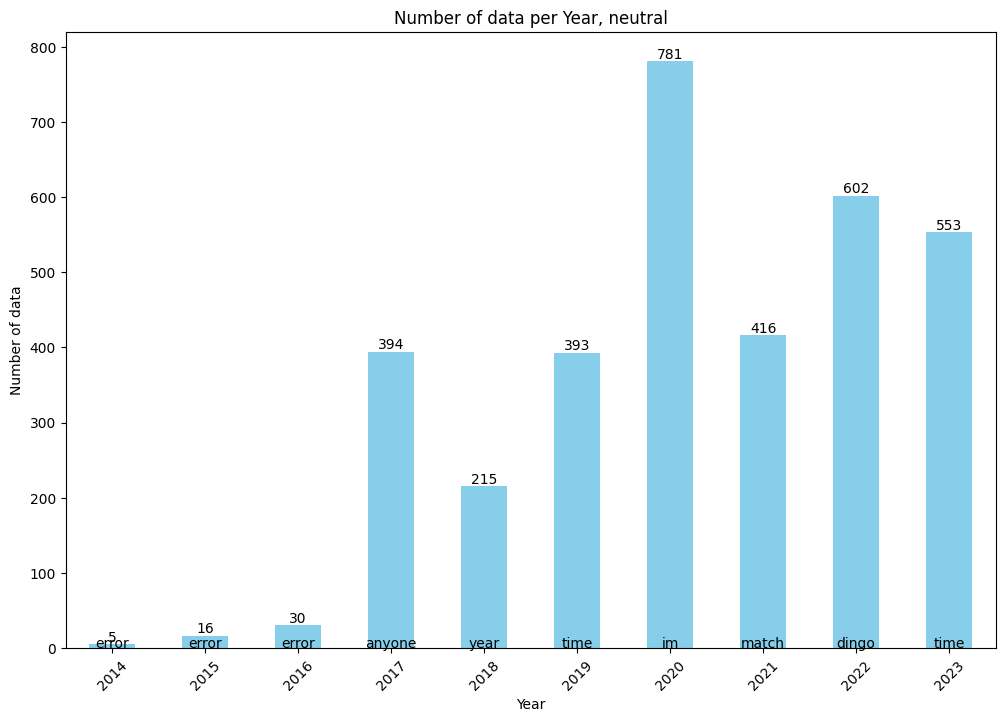

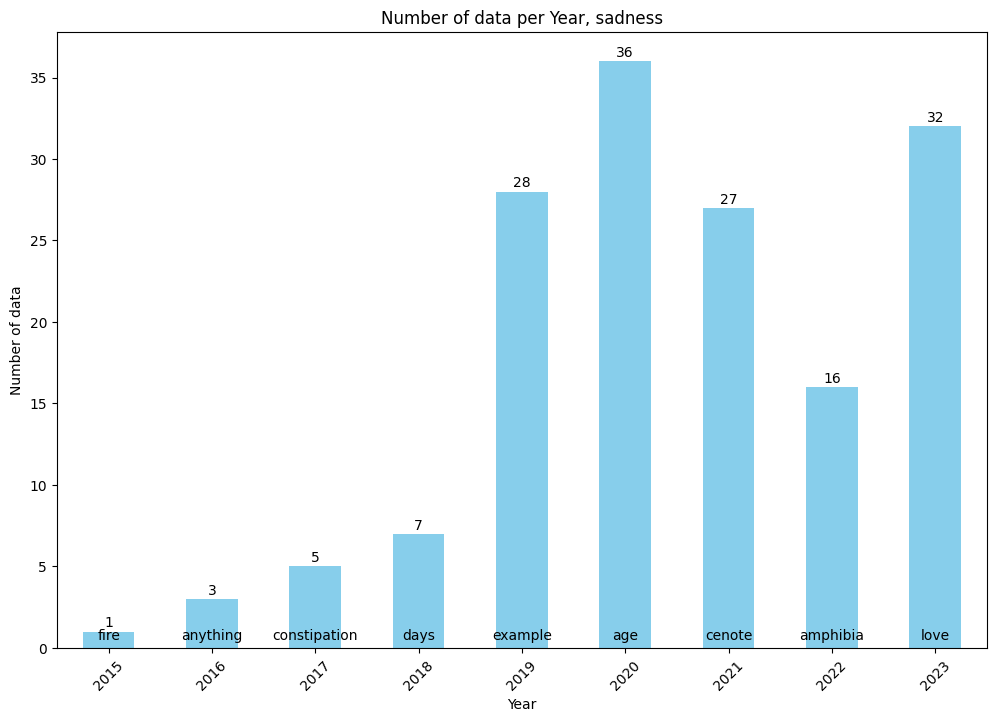

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:12:47,823 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:12:48,647 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 04:12:48,668 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:12:49,922 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-22 04:12:49,938 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:12:51,163 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:12:53,604 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:13:02,260 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:13:04,967 - BERTopic - Reduced dimensionality
2023-11-22 04:13:04,975 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-22 04:13:11,641 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:13:16,917 - BERTopic - Reduced dimensionality
2023-11-22 04:13:16,927 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:13:23,622 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:13:26,133 - BERTopic - Reduced dimensionality
2023-11-22 04:13:26,144 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:13:29,728 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:13:33,736 - BERTopic - Reduced dimensionality
2023-11-22 04:13:33,744 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 04:13:41,642 - BERTopic - Transformed documents to Embeddings
2023-11-22 04:13:44,119 - BERTopic - Reduced dimensionality
2023-11-22 04:13:44,126 - BERTopic - Clustered reduced embeddings


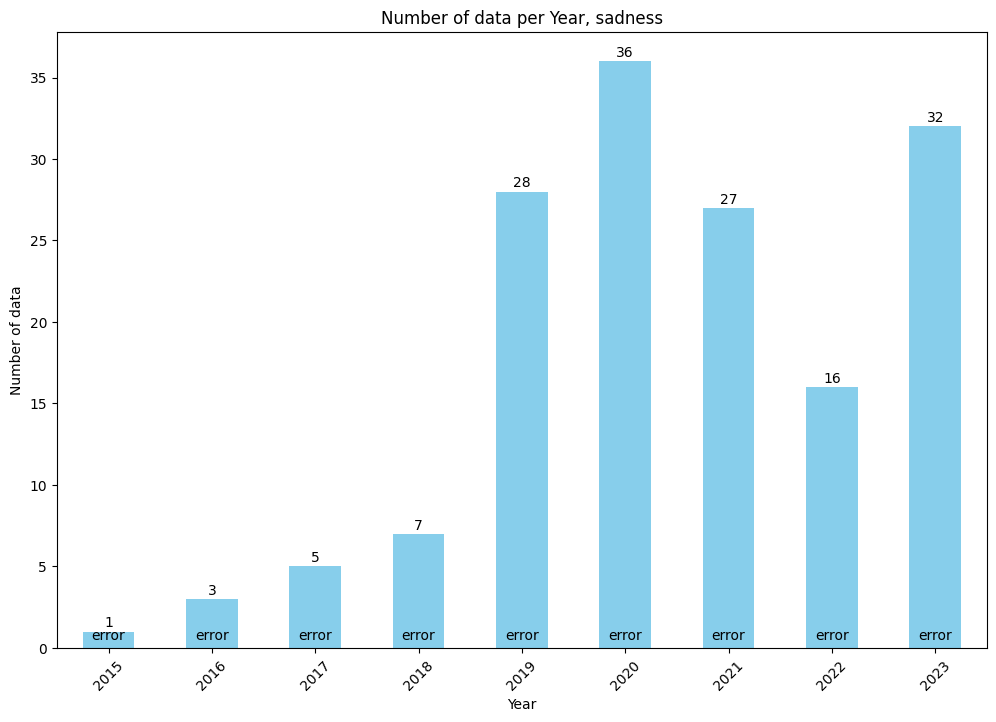

In [ ]:
emotion = ['joy','neutral','sadness']
for e in emotion:
    emotion_year_lda(e,df)
    emotion_year_topic(e, df, 1, 1)

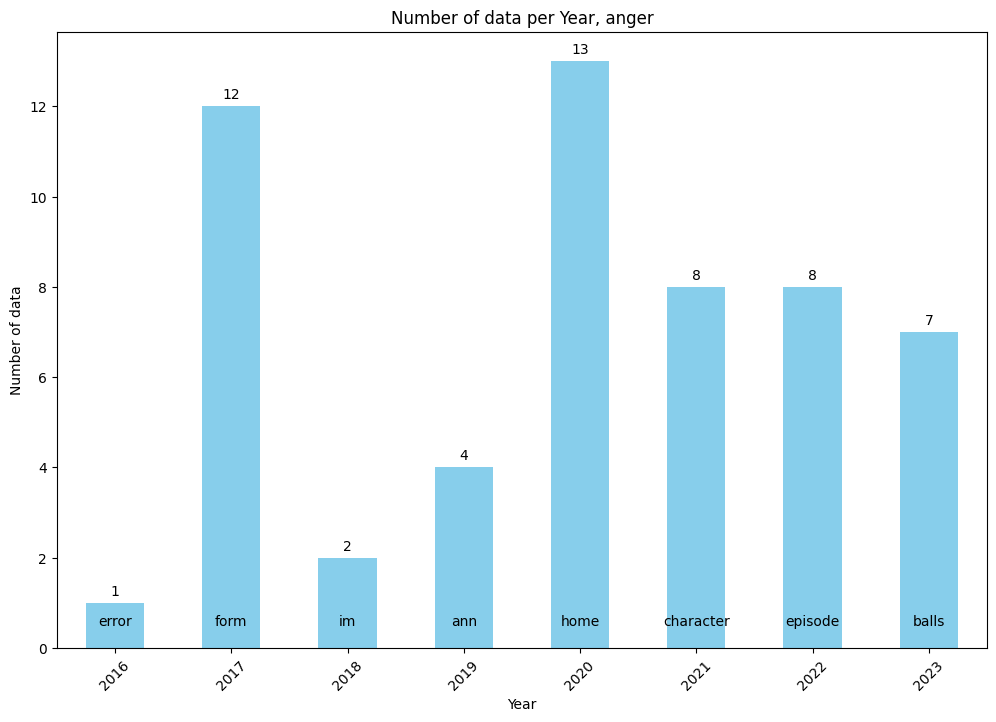

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:28,729 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:29,414 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:35,012 - BERTopic - Reduced dimensionality
2023-11-26 16:48:35,018 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:36,122 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:36,946 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:48:36,965 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:37,737 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:41,311 - BERTopic - Reduced dimensionality
2023-11-26 16:48:41,321 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:41,724 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:43,672 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:44,055 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:45,938 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:46,331 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:48,617 - BERTopic - Reduced dimensionality


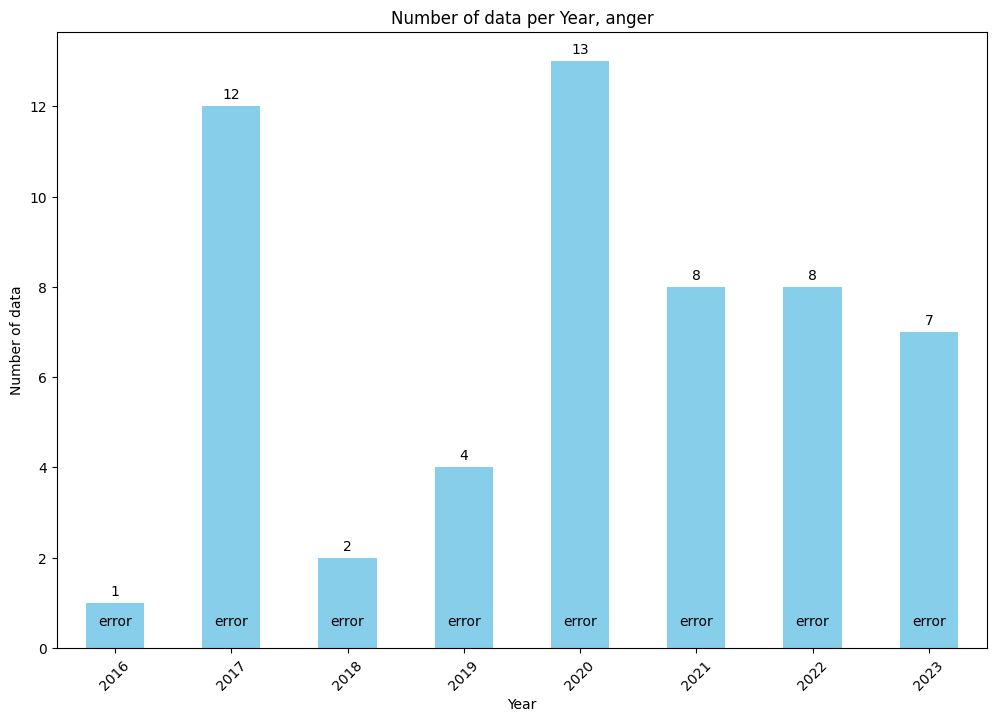

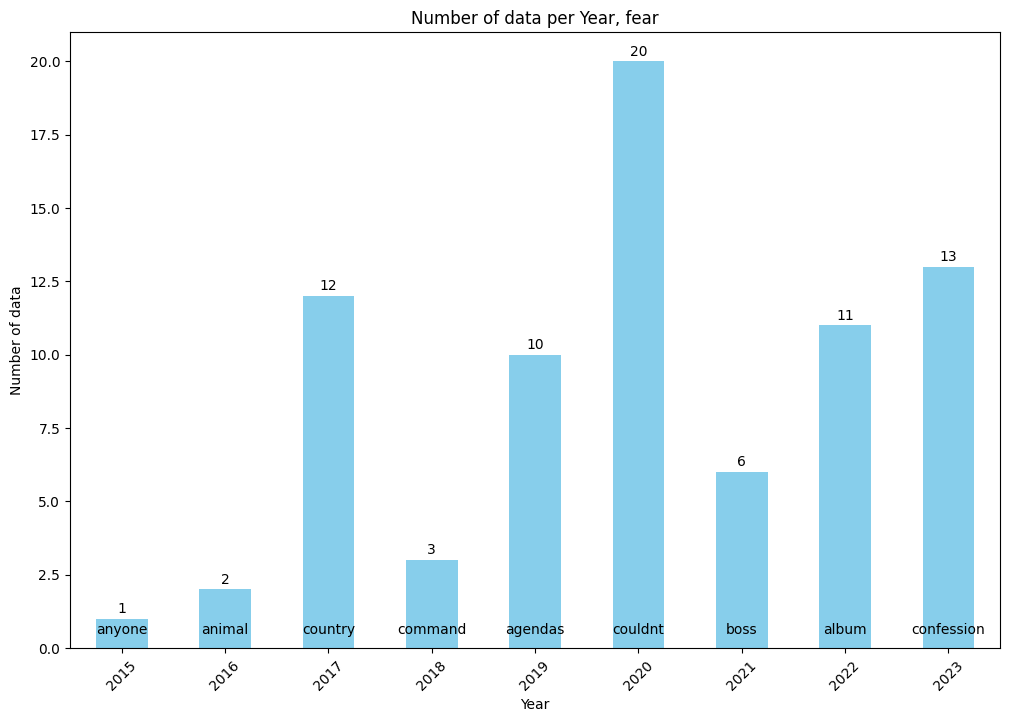

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:50,608 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:51,164 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:51,784 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:54,488 - BERTopic - Reduced dimensionality
2023-11-26 16:48:54,496 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:54,877 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:48:54,890 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:55,308 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:48:57,975 - BERTopic - Reduced dimensionality
2023-11-26 16:48:57,981 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:48:58,436 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:49:00,298 - BERTopic - Reduced dimensionality
2023-11-26 16:49:00,304 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:00,699 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:49:00,717 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:01,131 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:49:03,038 - BERTopic - Reduced dimensionality
2023-11-26 16:49:03,047 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:03,470 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:49:06,184 - BERTopic - Reduced dimensionality
2023-11-26 16:49:06,195 - BERTopic - Clustered reduced embeddings


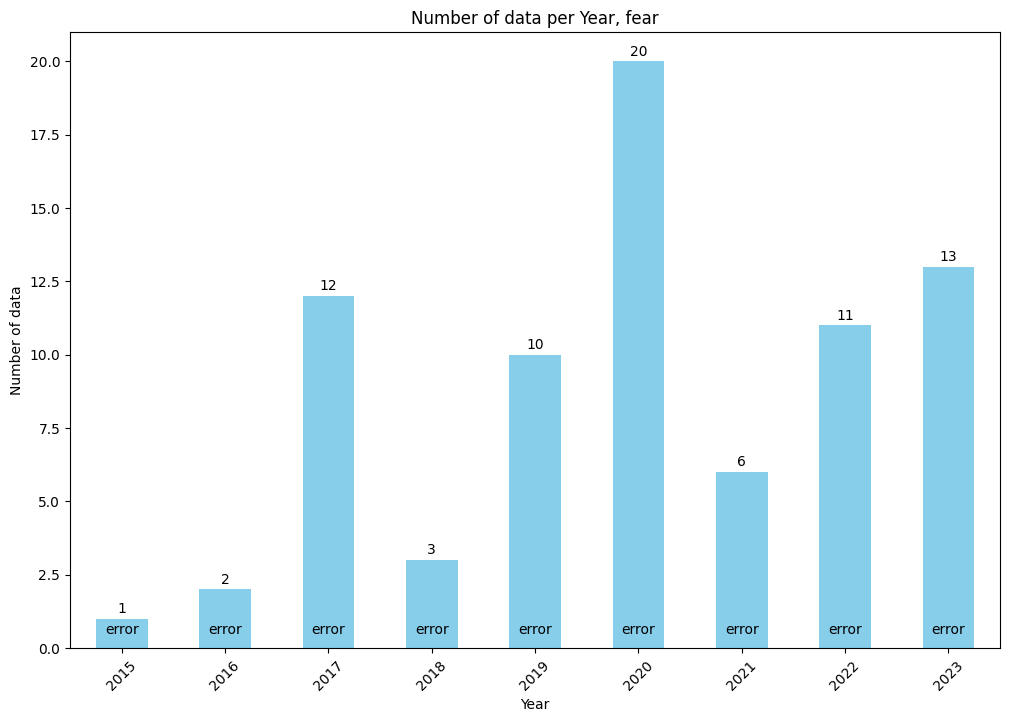

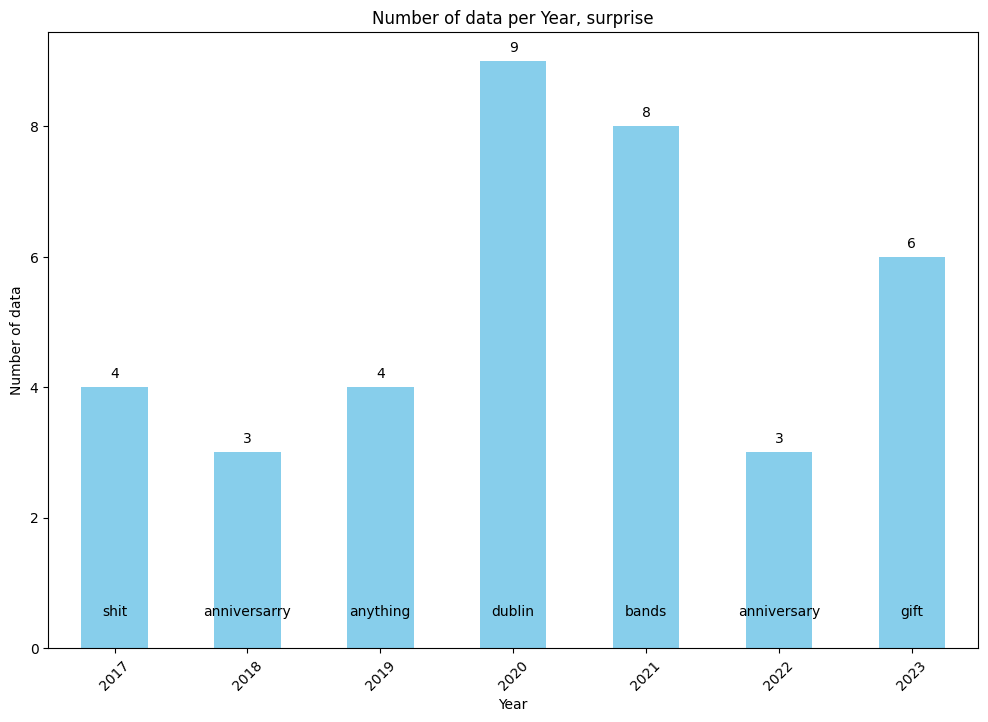

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:07,819 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:49:07,836 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:08,434 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:49:08,447 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:09,019 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:49:09,032 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:09,595 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:49:12,042 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:12,445 - BERTopic - Transformed documents to Embeddings
2023-11-26 16:49:15,196 - BERTopic - Reduced dimensionality


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:15,582 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:49:15,594 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-26 16:49:15,984 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
2023-11-26 16:49:15,994 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


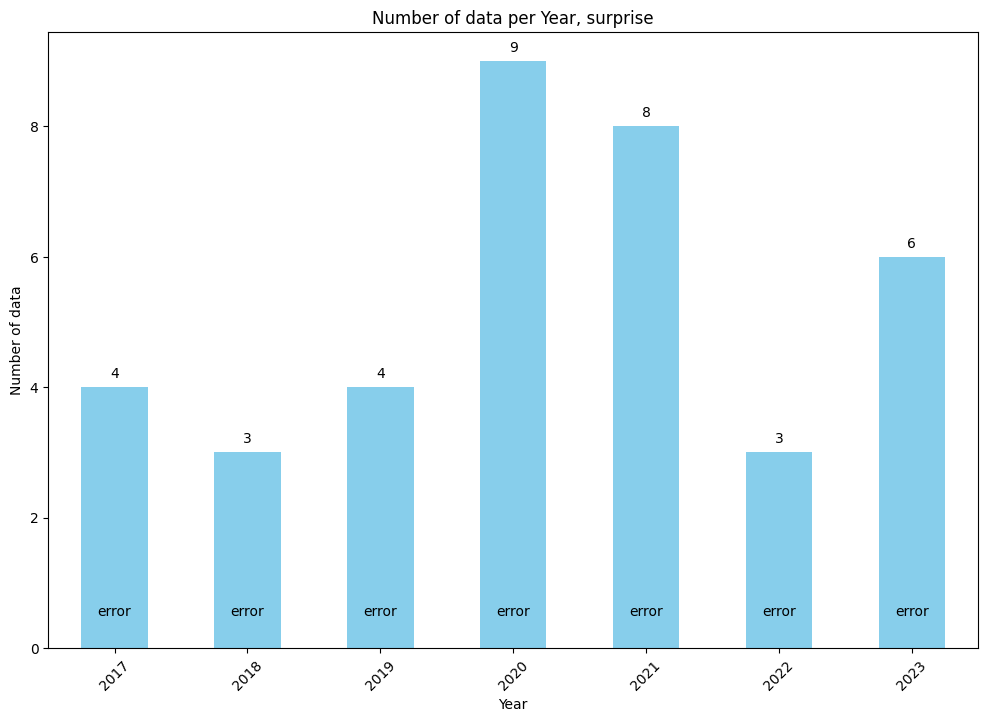

In [ ]:
emotion = ['anger','fear','surprise']
for e in emotion:
    emotion_year_lda(e,df)
    emotion_year_topic(e, df, 1, 1)

#### Stat graphs

In [ ]:
emotions = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise"]
e_dict = {}
for i in emotions:
    try:
        count = df['top_emotion'].value_counts()[i]
        e_dict[i] = count
    except:
        e_dict[i] = 0
print(e_dict)

{'admiration': 281, 'amusement': 113, 'anger': 55, 'annoyance': 83, 'approval': 37, 'caring': 33, 'confusion': 55, 'curiosity': 168, 'desire': 64, 'disappointment': 81, 'disapproval': 47, 'disgust': 18, 'embarrassment': 8, 'excitement': 74, 'fear': 78, 'gratitude': 158, 'grief': 0, 'joy': 127, 'love': 260, 'nervousness': 34, 'optimism': 44, 'pride': 3, 'realization': 32, 'relief': 0, 'remorse': 45, 'sadness': 155, 'surprise': 37}


<Figure size 2000x1000 with 0 Axes>

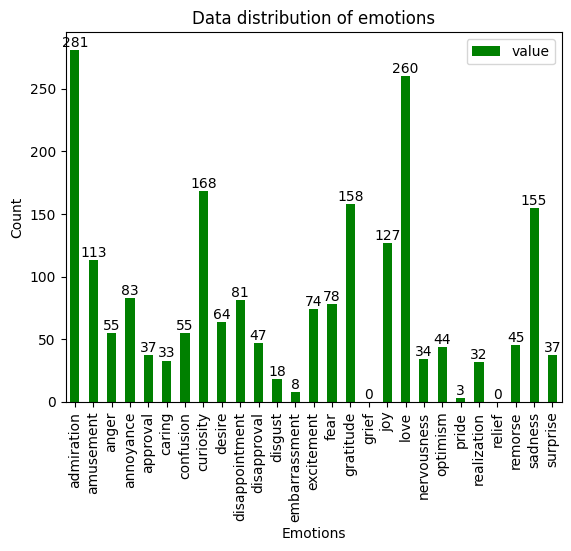

In [ ]:
e = pd.DataFrame(e_dict.items(), columns=['key', 'value'])

# Create a bar chart
plt.figure(figsize=(20, 10))
e.plot(kind='bar', x='key', y='value', color='green')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Data distribution of emotions')

# Add numbers on top of the bars
for i, v in enumerate(e['value']):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()
